In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import RMSprop
from grid_cells import GridCells
from utils import get_coords, to_tensor, get_loc_batch
from agent import Agent
from tqdm import tqdm

In [2]:
def eval_position(agent, coords, grid_cells, size=4096):
    losses = list()
    for _ in range(size // 256):
        x, y = get_loc_batch(coords, grid_cells, bs=256)
        x = agent.actor(x)[1]
        loss = torch.sum((x - y)**2).detach().cpu().numpy()
        losses.append(loss)
    return np.mean(losses)

def print_stats(w):
    print("min   |max  |mean |std  |shape")
    print(f"{w.min():.03f}|{w.max():.03f}|{w.mean():.03f}|{w.std():.03f}|{w.shape}")

In [3]:
resolution = 400
MIN, MAX = -1, 1
N = 100
scales = np.linspace(90, 300, 10, dtype=int)

coords = get_coords(resolution, MIN, MAX)
gcs = GridCells(scales, n_per_module=N, res=resolution)
gcs.reset_modules(1)
gcs.compile_numpy()
grid_cells = to_tensor(gcs.grid_cells.transpose(1, 2, 0))

In [4]:
hidden = 500
wd_l1 = 1e-5
wd_l2 = 1e-7
hidden_penalty = 2e-2

agent = Agent(grid_cells.shape[-1], 2, actor_hidden=hidden, lr_a=1e-4)
net = agent.actor
optim = RMSprop([p for p in net.parameters()], lr=3e-4)

In [5]:
losses = list()
for _ in tqdm(range(50000)):
    optim.zero_grad()
    net.clamp_weights()
    x, y = get_loc_batch(coords, grid_cells, bs=256)
    _, pred = net(x)
    loss = torch.sum((pred - y)**2, dim=-1).mean()
    loss += net.hidden_loss(hidden_penalty)
    loss += net.regularization_loss(wd_l1, wd_l2)
    loss.backward()
    optim.step()
    losses.append(loss.detach().cpu().item())

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [17:47<00:00, 46.86it/s]


In [18]:
net.clamp_weights()

print_stats(net.b1)
print_stats(net.w1)
print_stats(net.w1.sum(1))

min   |max  |mean |std  |shape
-3.442|6.116|2.058|2.849|torch.Size([500])
min   |max  |mean |std  |shape
0.000|6.484|0.004|0.070|torch.Size([500, 1000])
min   |max  |mean |std  |shape
0.061|26.849|3.840|6.591|torch.Size([500])


Position loss: 0.421


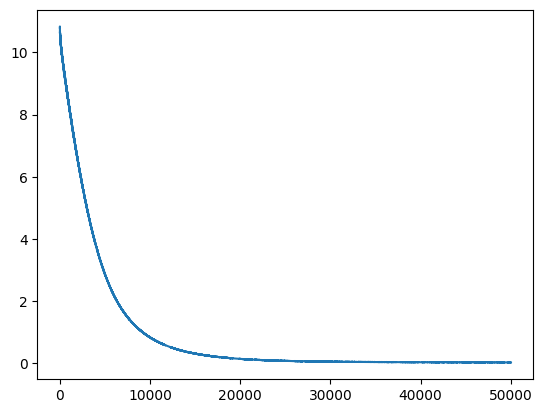

In [11]:
print(f"Position loss: {eval_position(agent, coords, grid_cells):.03f}")
plt.plot(losses)
plt.show()

In [12]:
idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:].numpy() + [[0], [hidden]]
print(net.lin2.weight[2:].detach().cpu().flatten()[idx.flatten()])

tensor([ 6.6697, -6.6808, -6.7138, -6.9035, -7.1767,  6.8886,  6.9384,  7.4052,
        -7.4367,  7.6656])


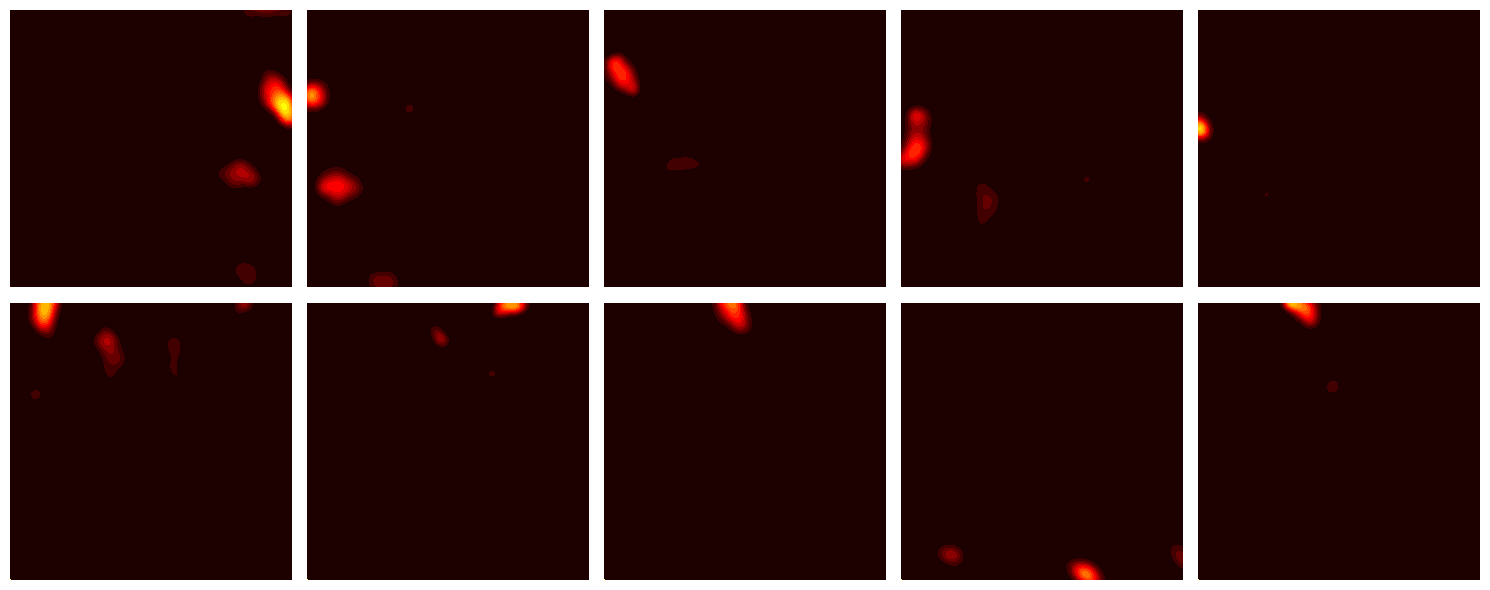

In [13]:
_, axs = plt.subplots(2, 5, figsize=(15, 6))

hidden = net.lin1(grid_cells).permute((-1, 0, 1)).detach().cpu().numpy()
# Small hack to ensure the scale of every plot is the same
hidden[:,0,0] = hidden.max()
hidden[:,0,1] = hidden.min()

idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:]
for img, ax in zip(hidden[idx.flatten()], axs.flatten()):
    ax.contourf(img, levels=20, cmap='hot')
    ax.axis('off')
plt.tight_layout()
plt.show()

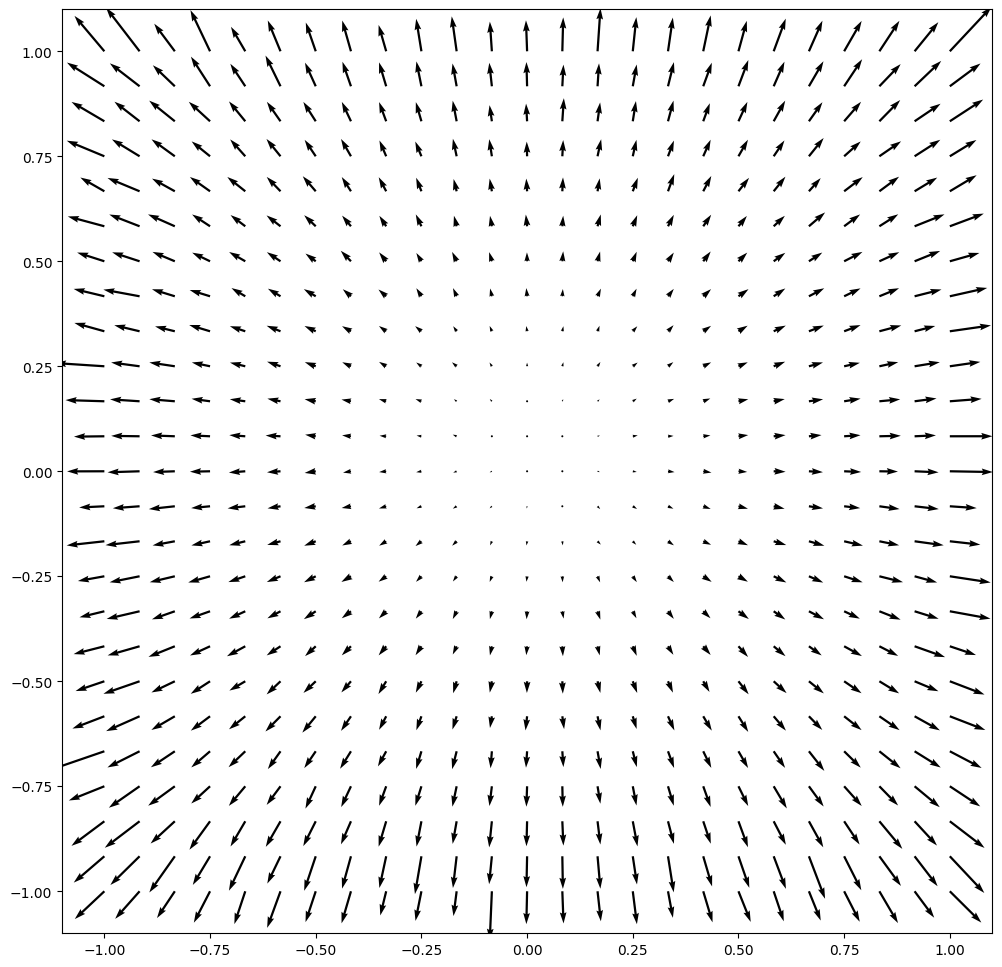

In [14]:
xy = np.linspace(-1, 1, 25)
X, Y = np.meshgrid(xy, xy)

plt.figure(figsize=(12, 12))
plt.quiver(X, Y, *net.lin2(net.lin1(grid_cells))[::16,::16,2:].permute(-1, 0, 1).detach().cpu())
plt.show()

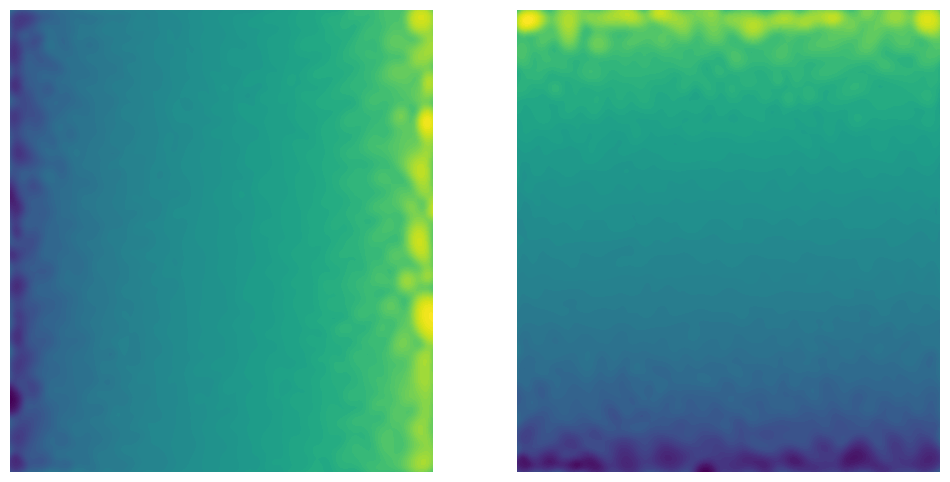

In [15]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.axis('off')
ax2.axis('off')
ax1.contourf(net.lin2(net.lin1(grid_cells))[:,:,2].detach().cpu(), levels=100)
ax2.contourf(net.lin2(net.lin1(grid_cells))[:,:,3].detach().cpu(), levels=100)
plt.show()

min   |max  |mean |std  |shape
-7.437|7.666|-0.149|4.223|torch.Size([2, 123])
min   |max  |mean |std  |shape
-5.713|5.706|-0.033|0.971|torch.Size([2, 377])


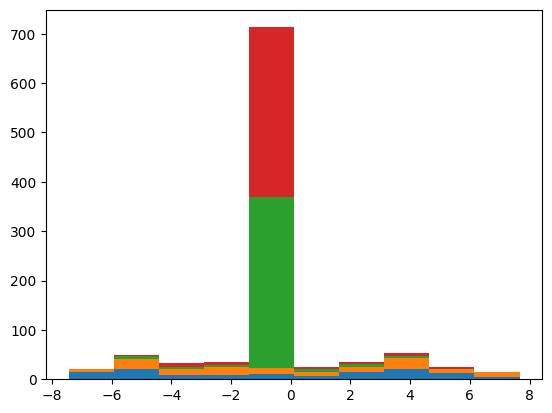

In [16]:
used = hidden.mean((1, 2)) > hidden.mean()# + hidden.mean((1, 2)).std() / 20

print_stats(net.lin2.weight[2:, used])
print_stats(net.lin2.weight[2:, ~used])

plt.hist([*net.lin2.weight[2:, used].detach().cpu(),
          *net.lin2.weight[2:, ~used].detach().cpu()],
         histtype='barstacked')
plt.show()

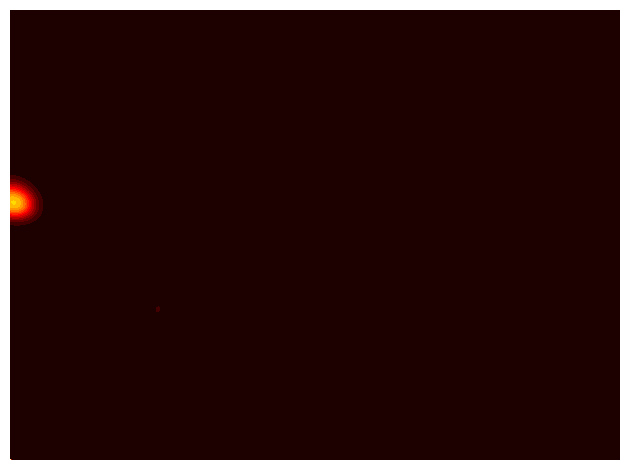

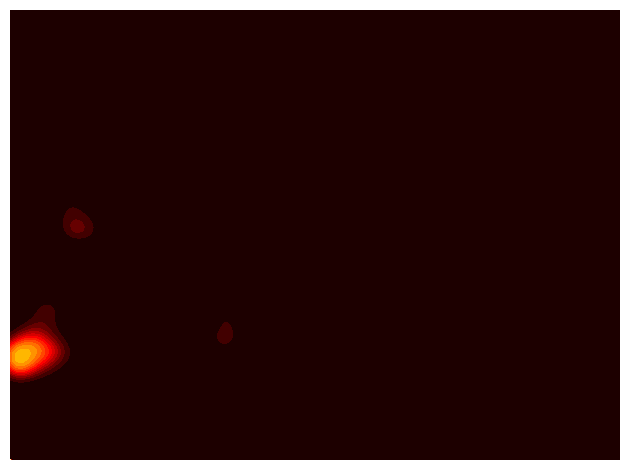

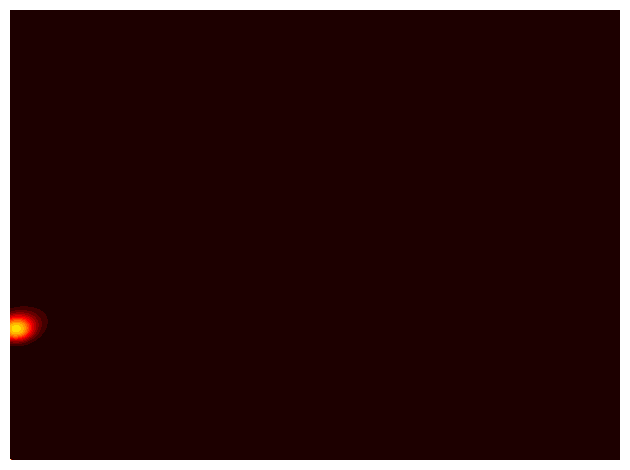

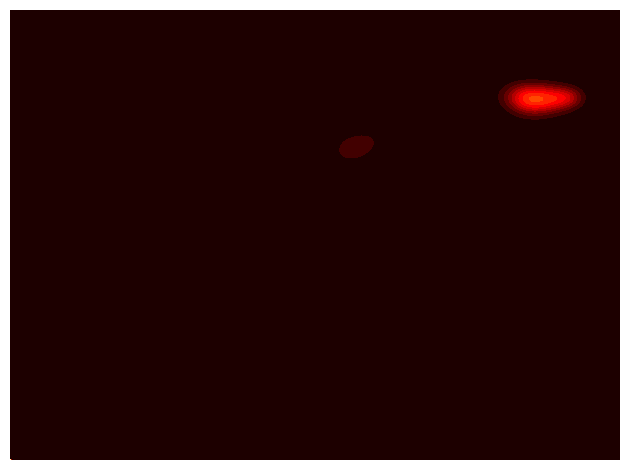

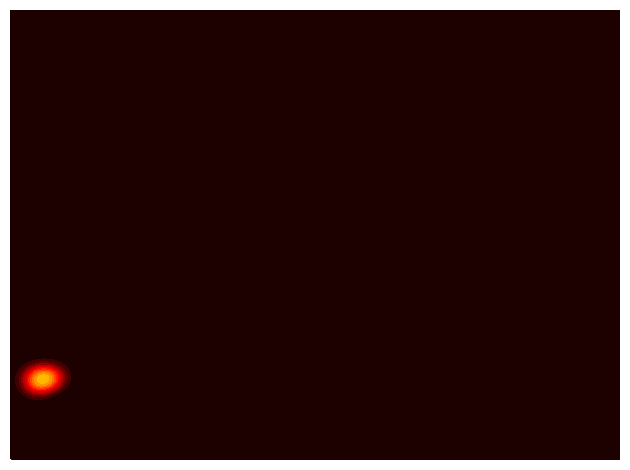

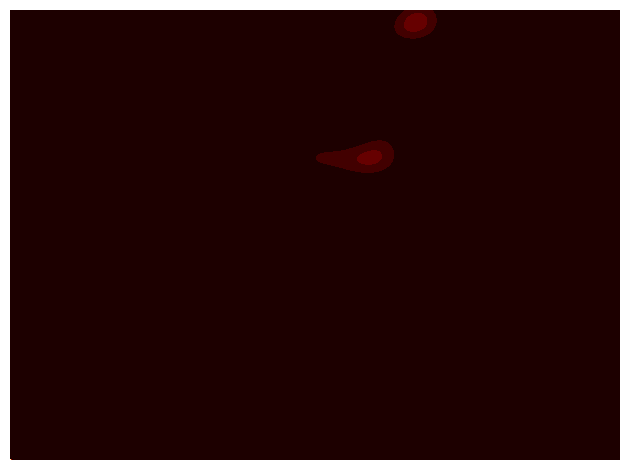

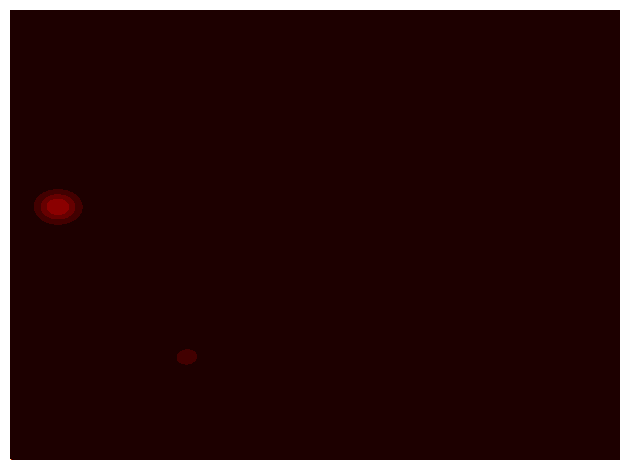

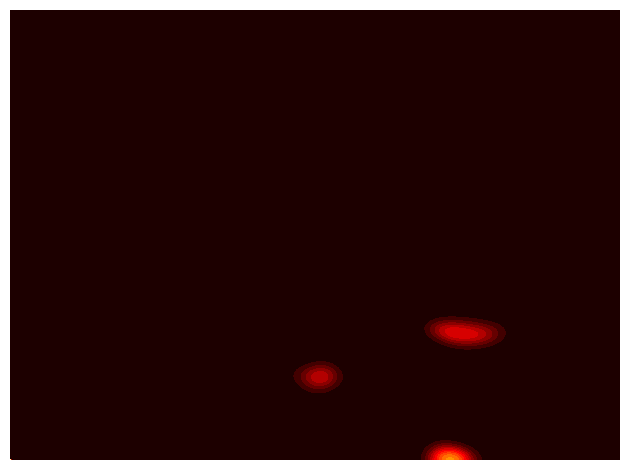

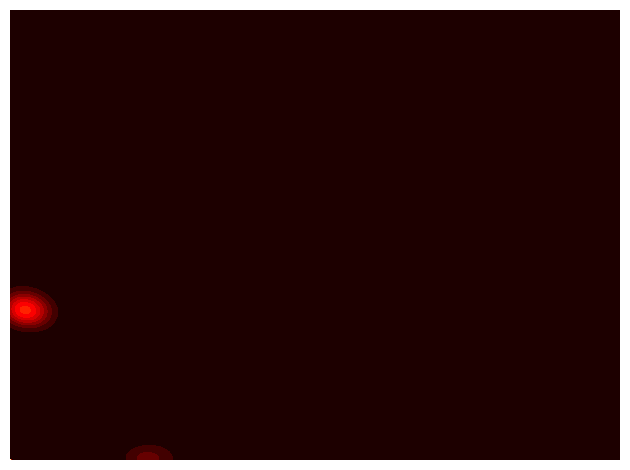

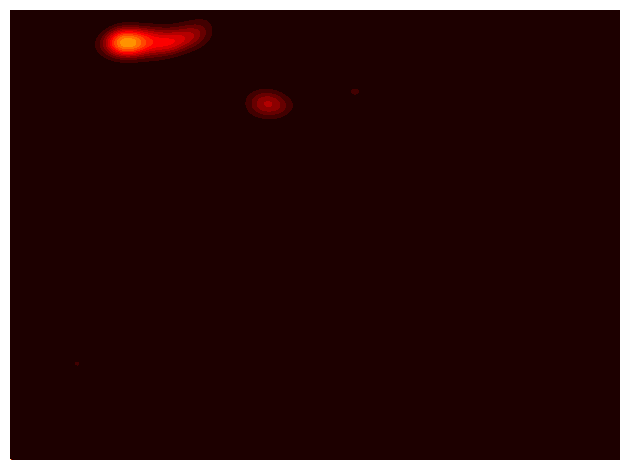

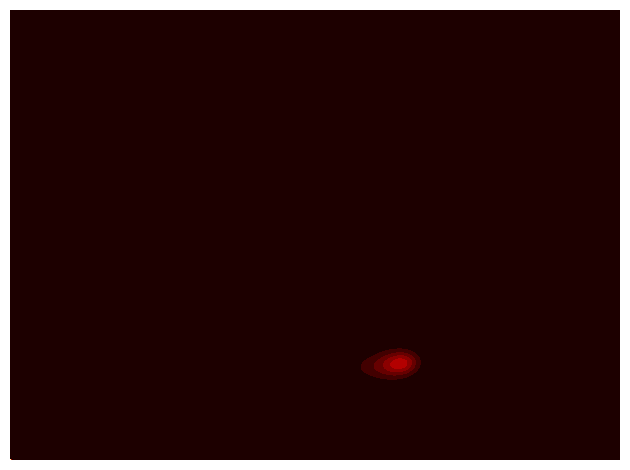

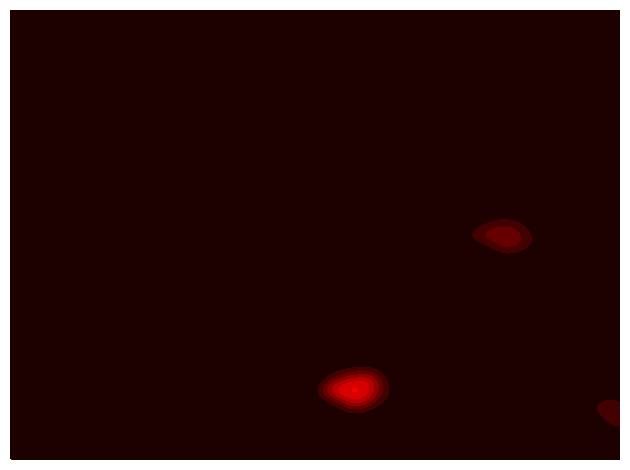

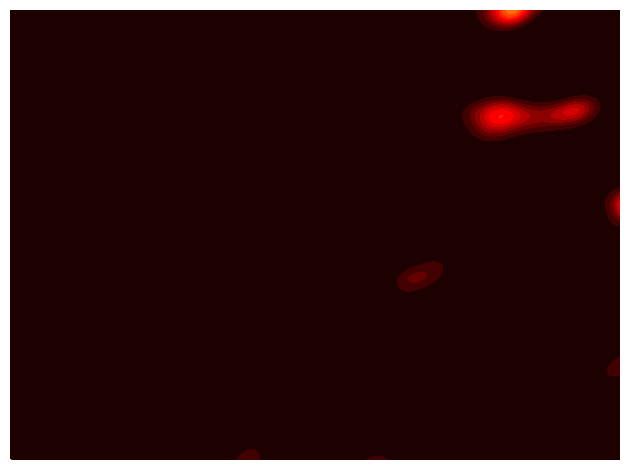

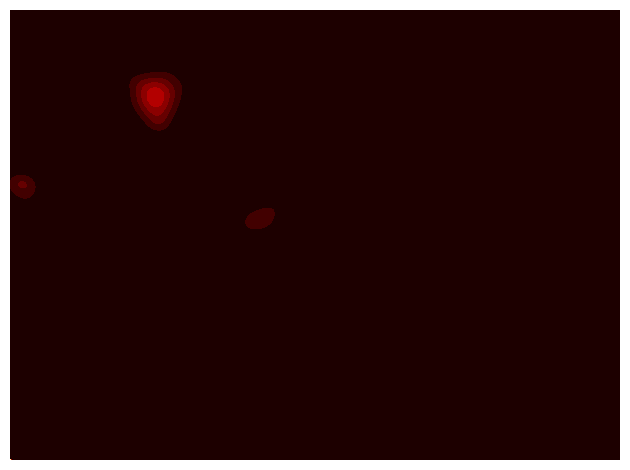

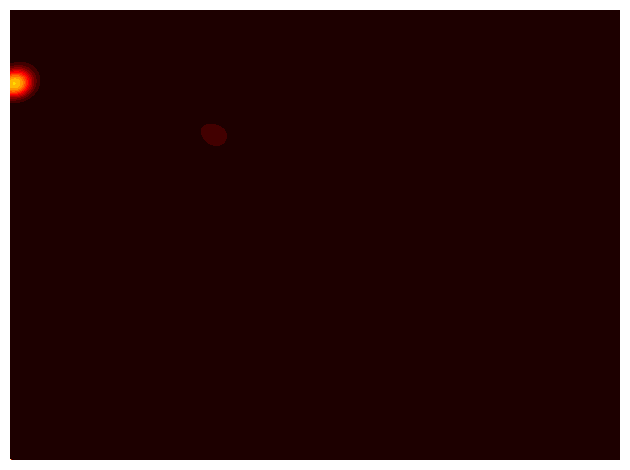

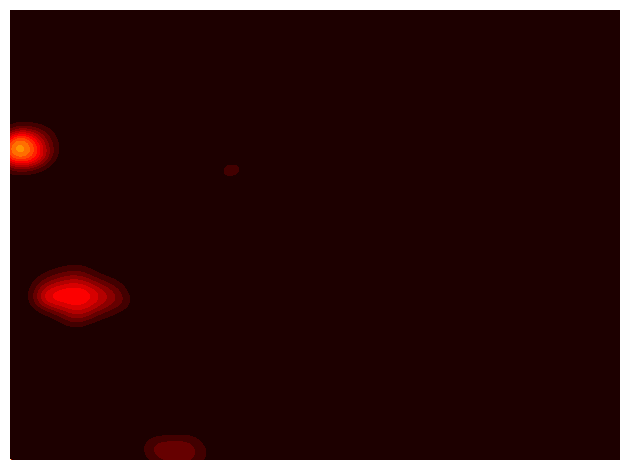

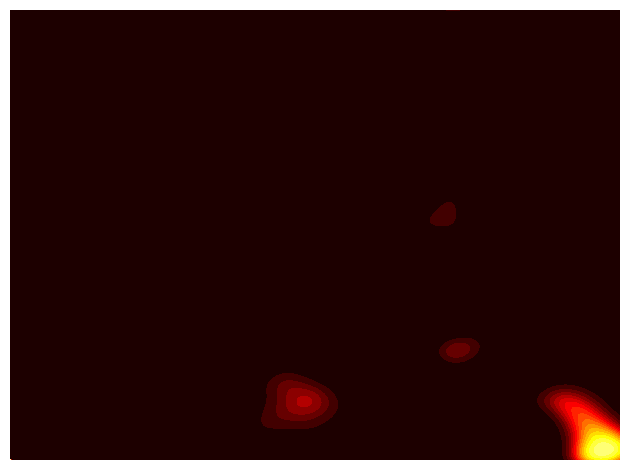

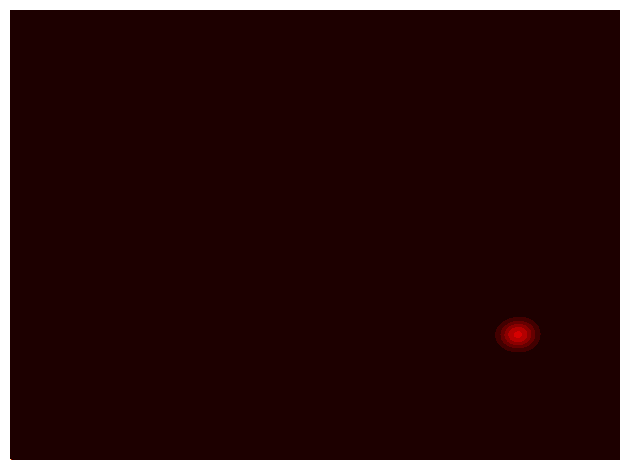

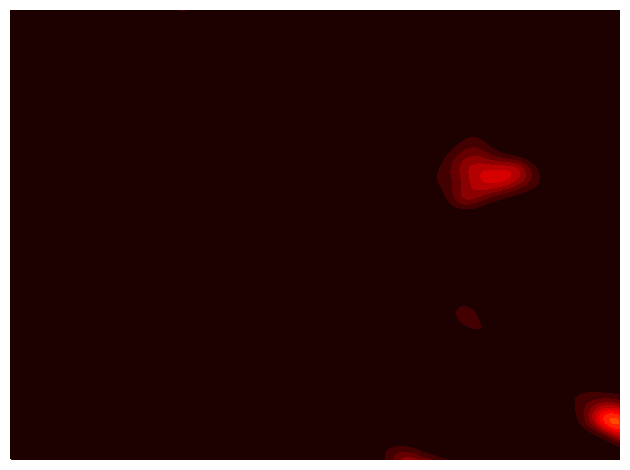

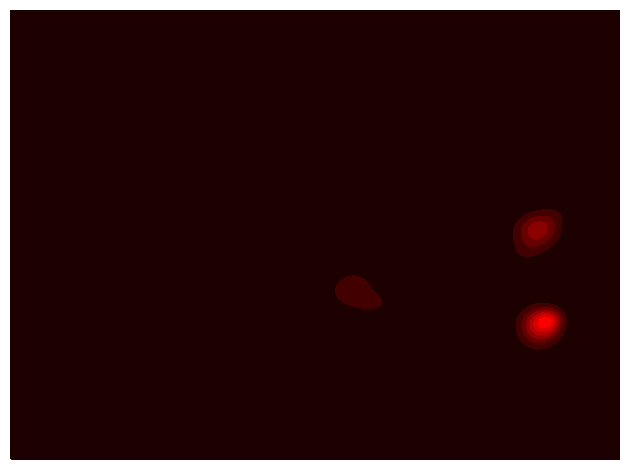

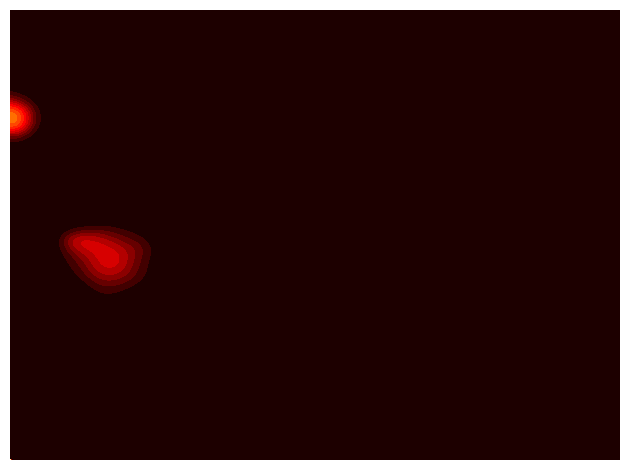

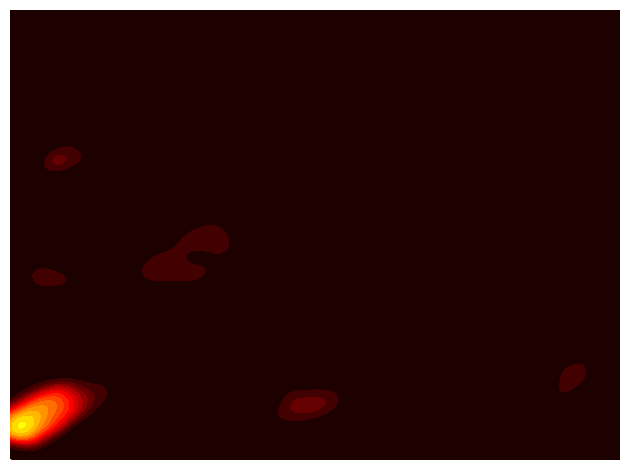

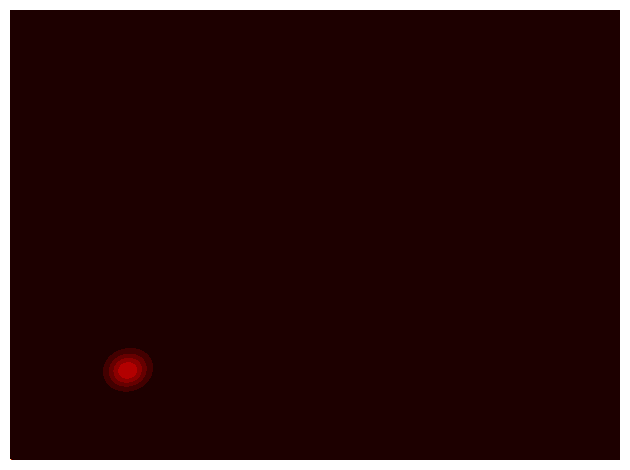

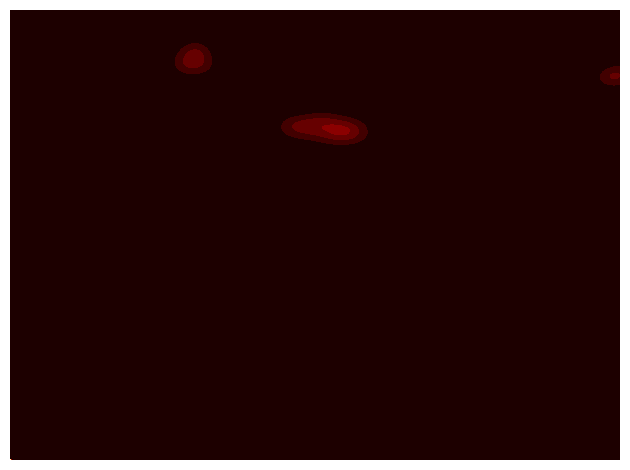

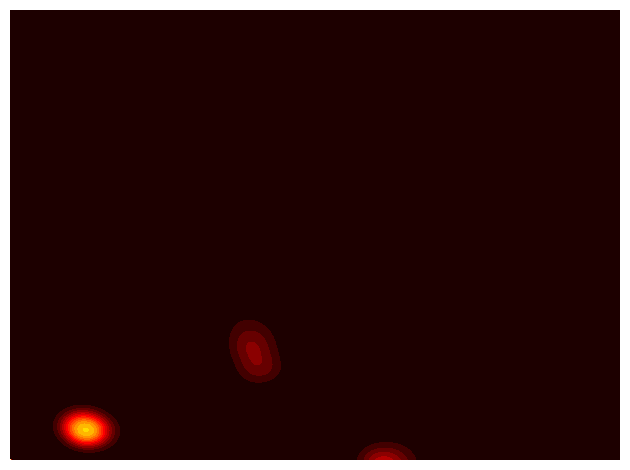

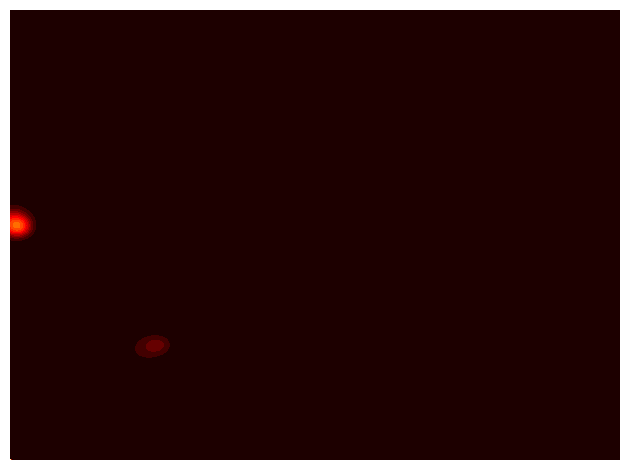

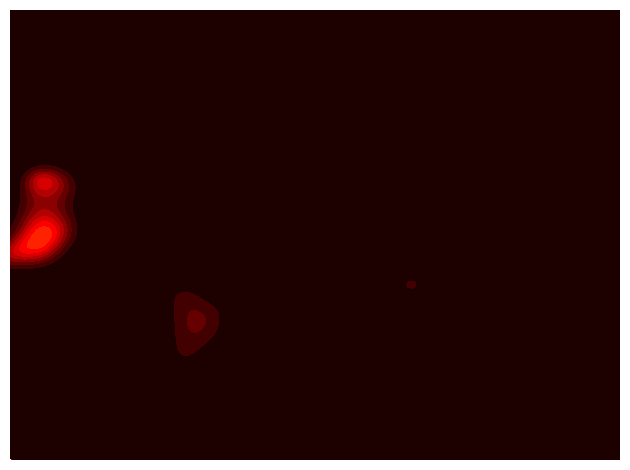

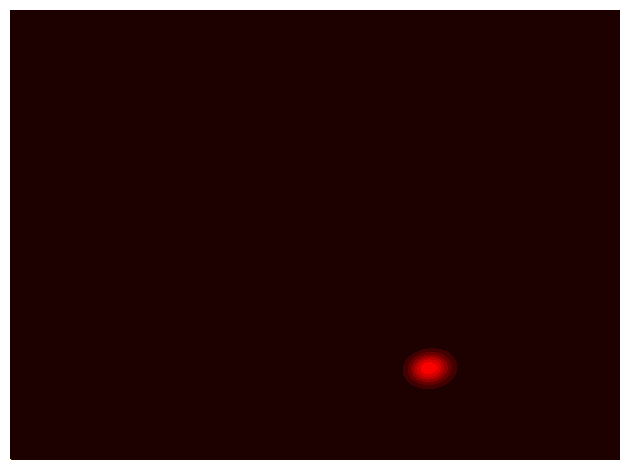

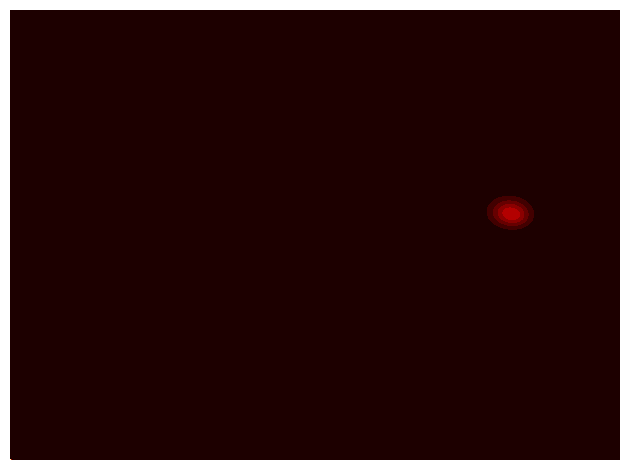

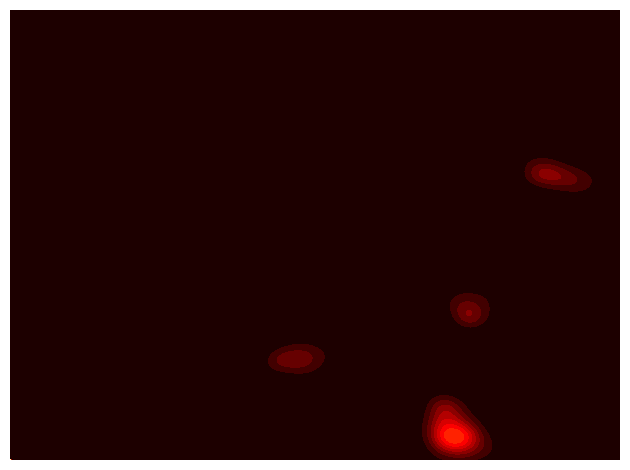

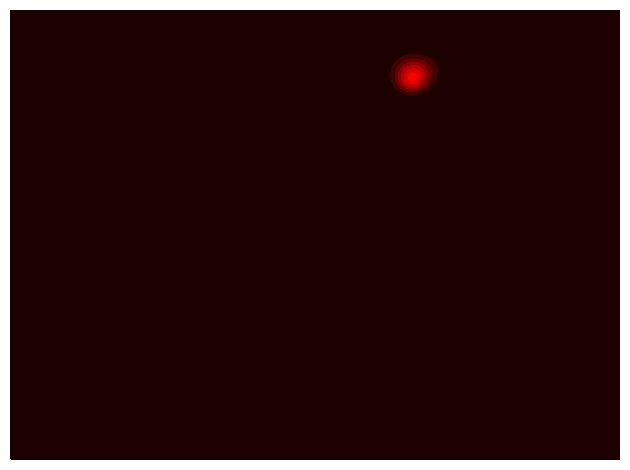

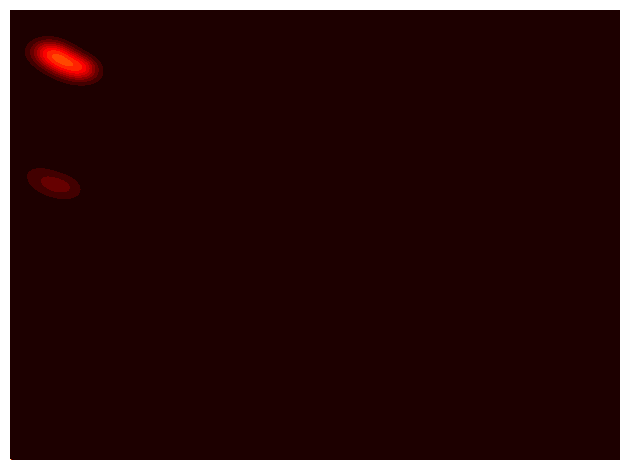

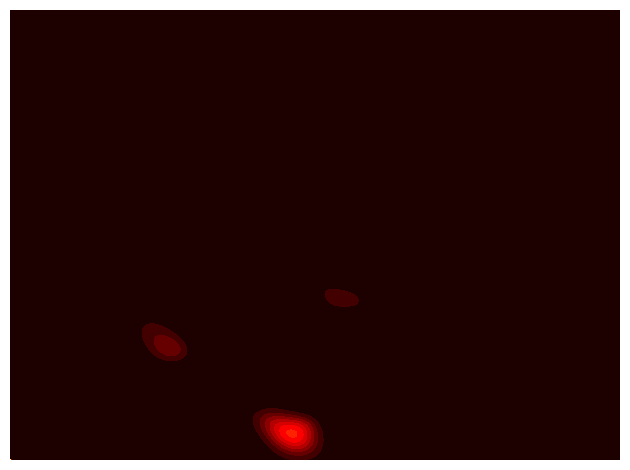

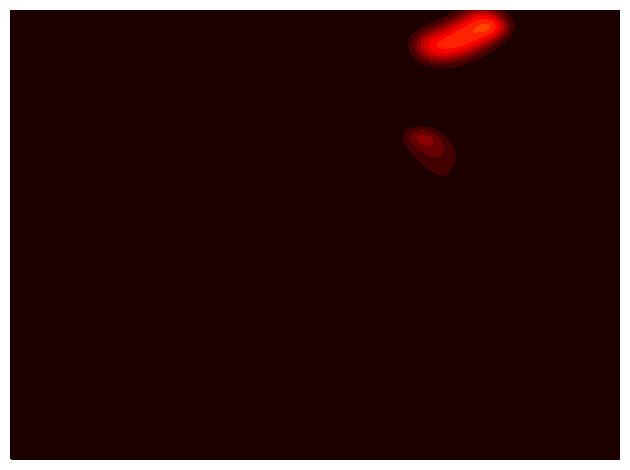

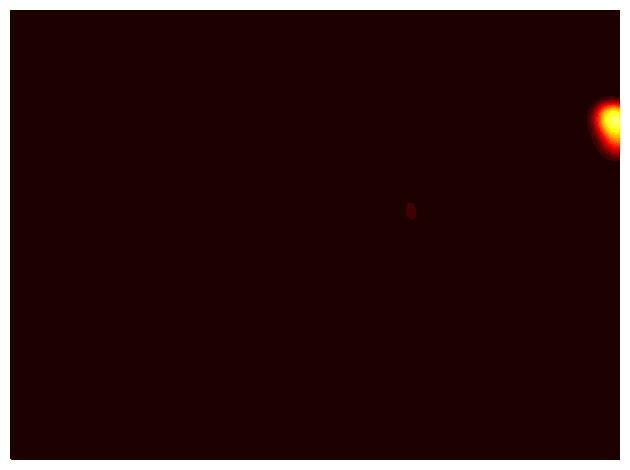

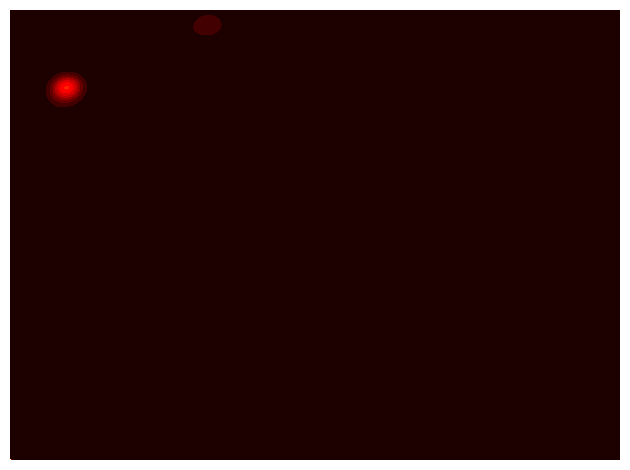

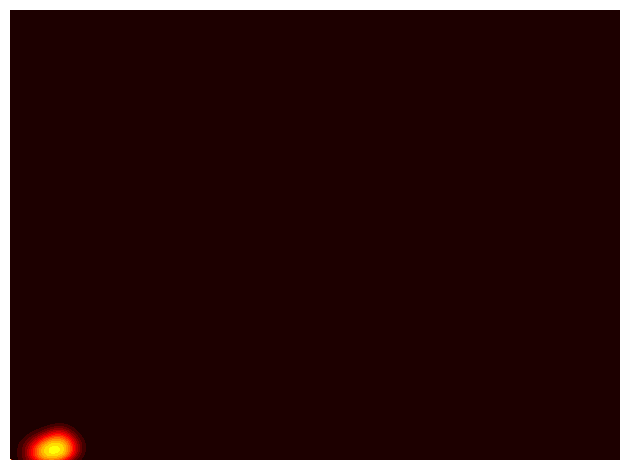

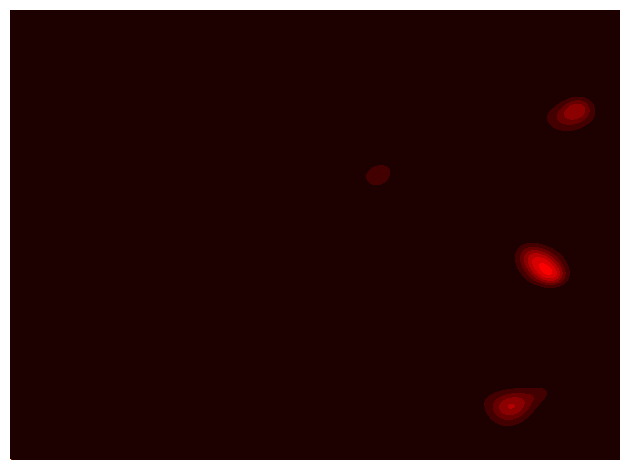

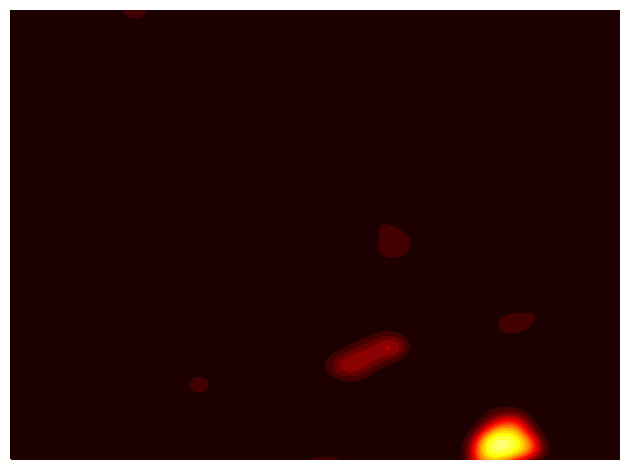

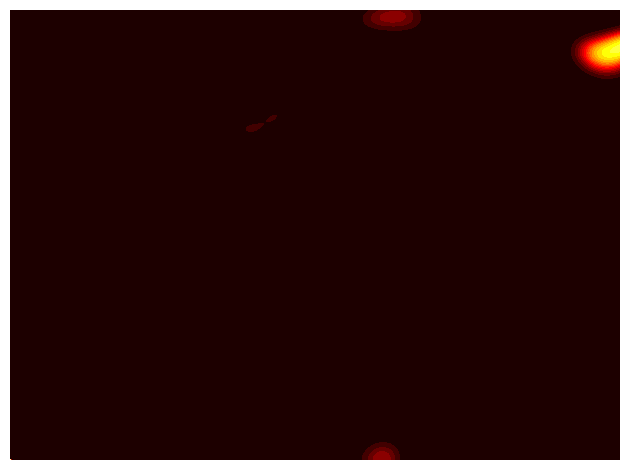

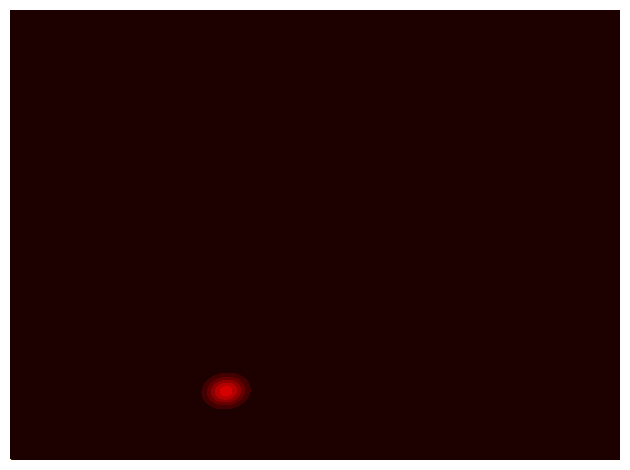

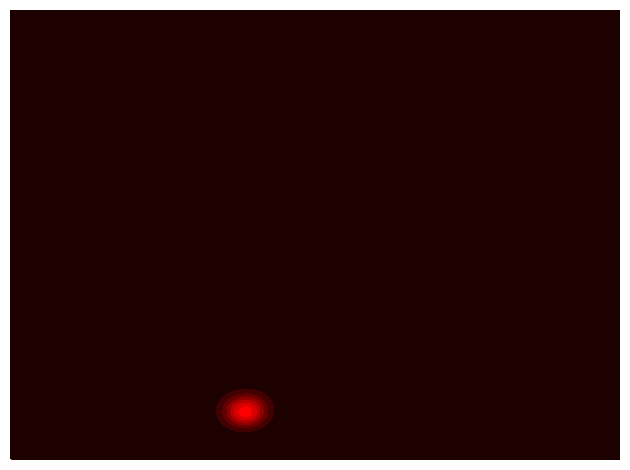

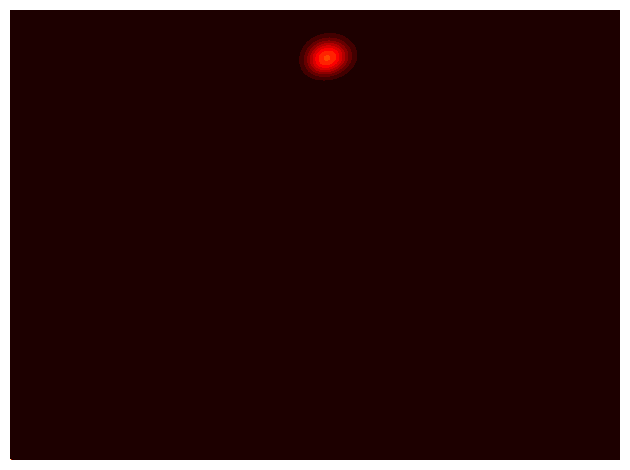

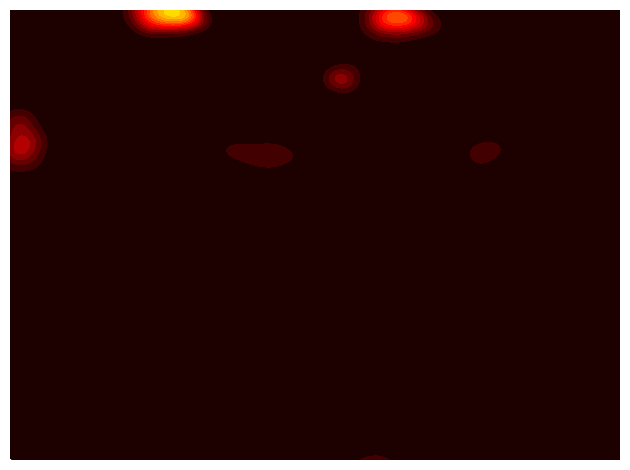

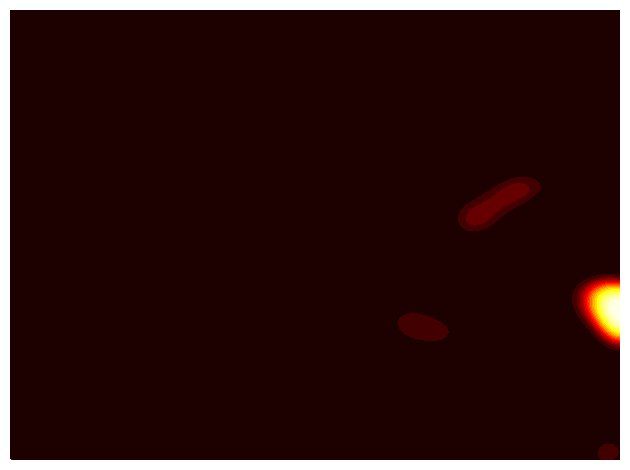

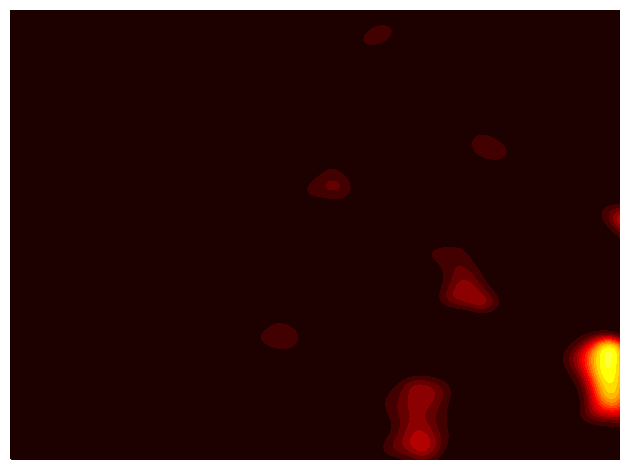

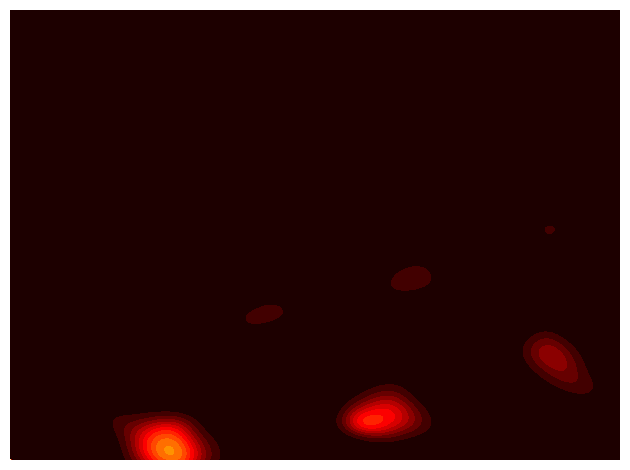

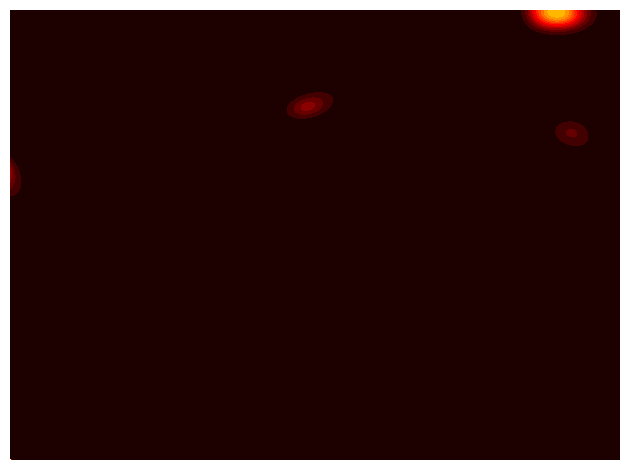

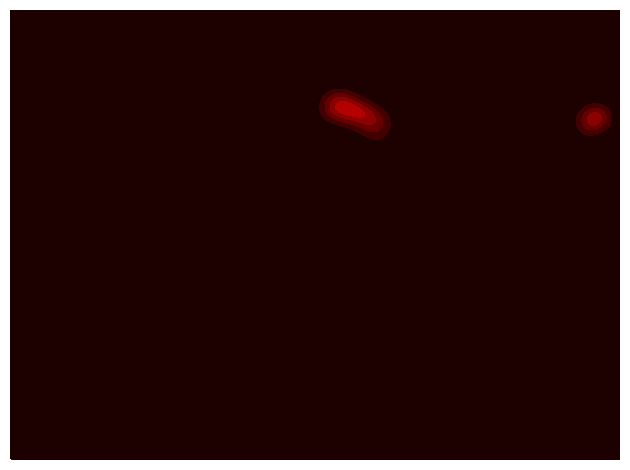

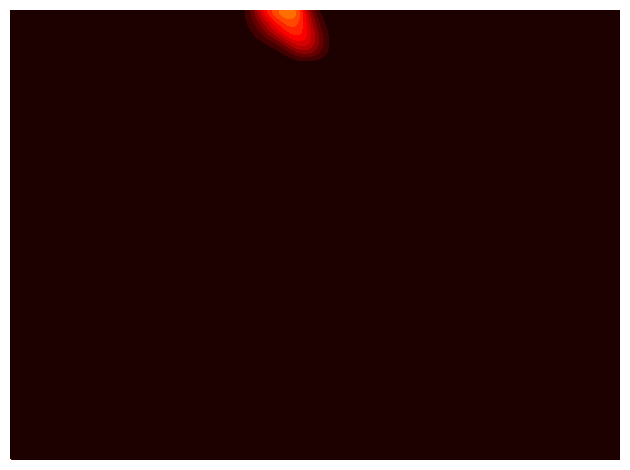

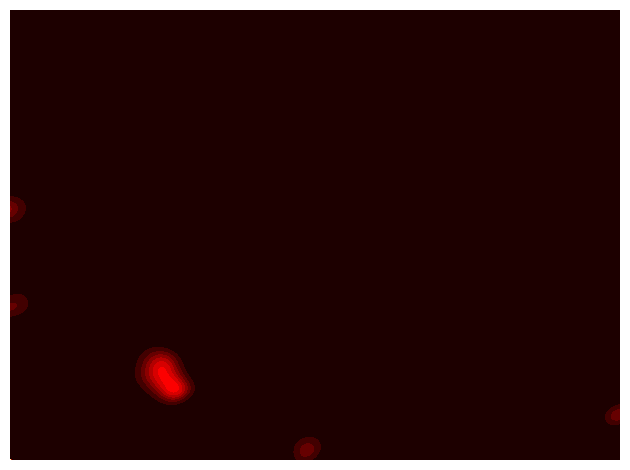

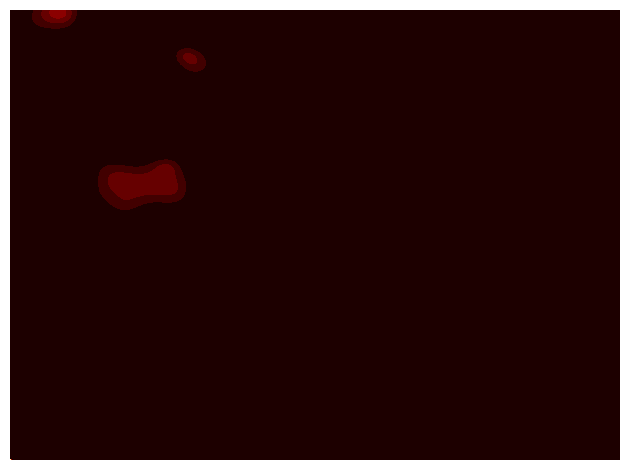

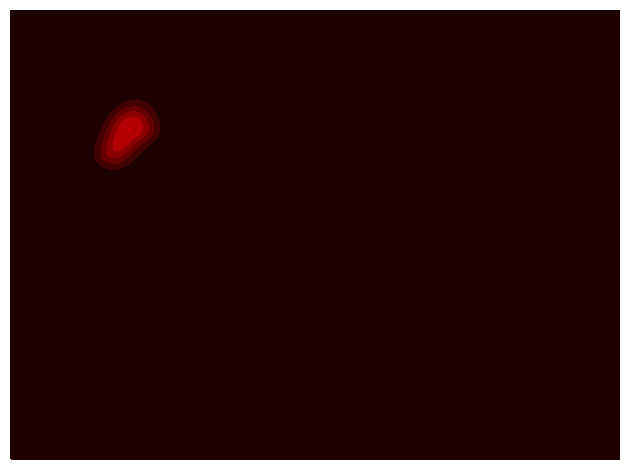

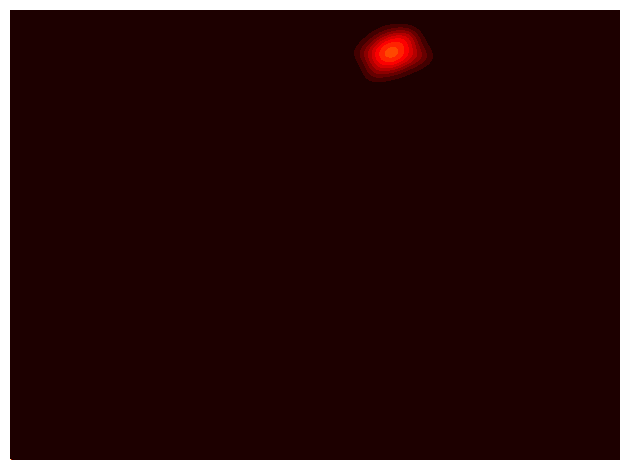

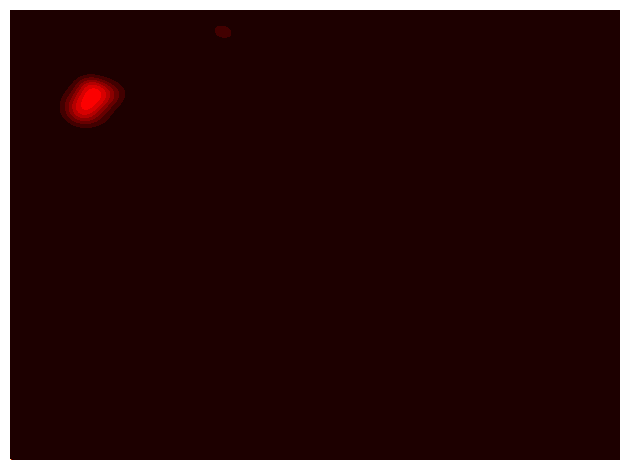

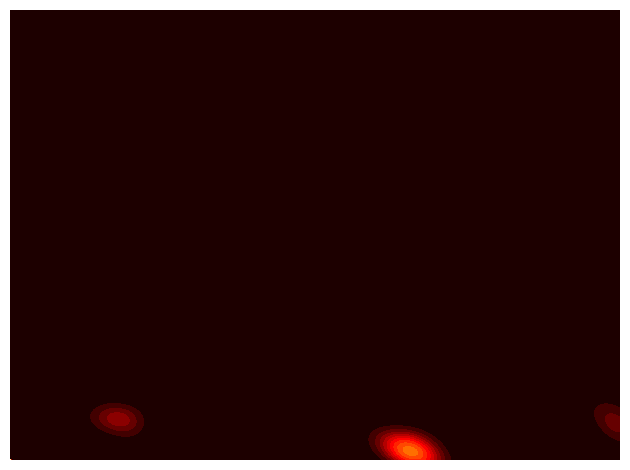

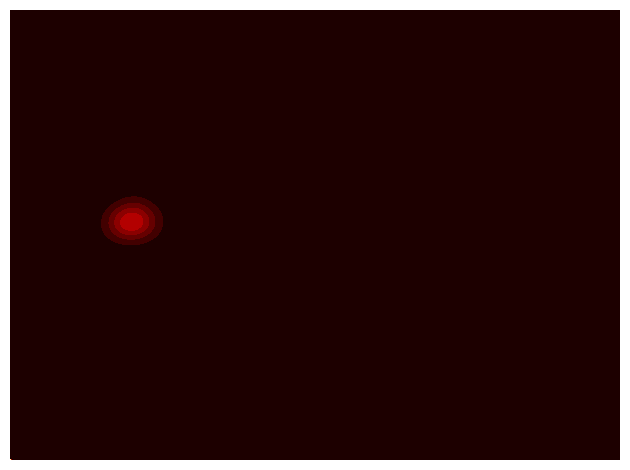

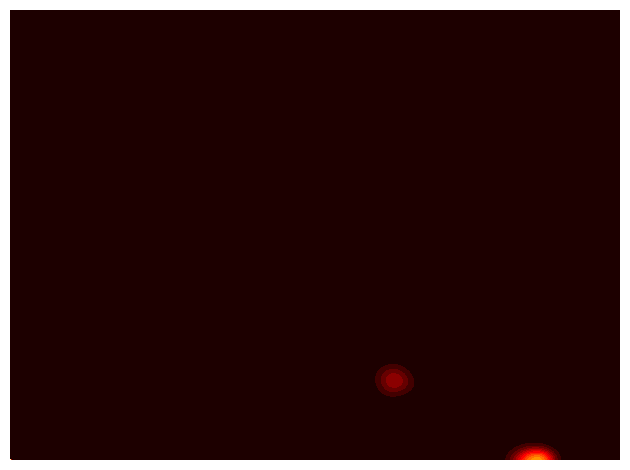

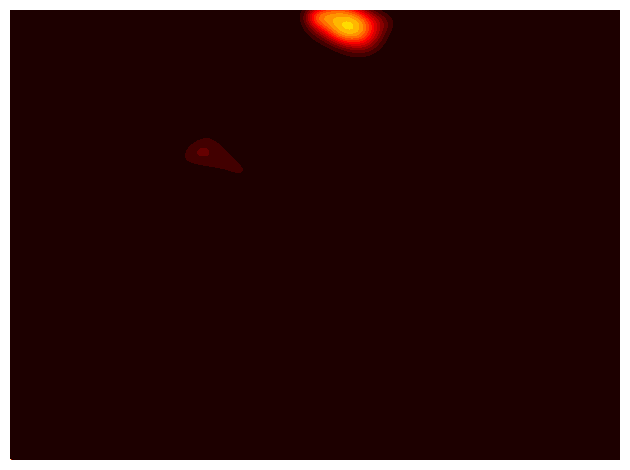

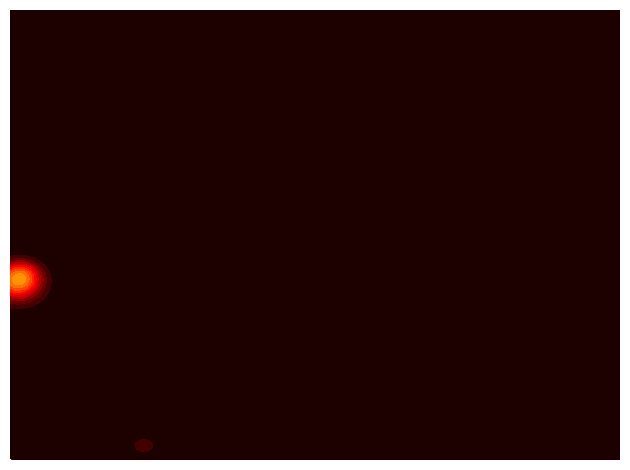

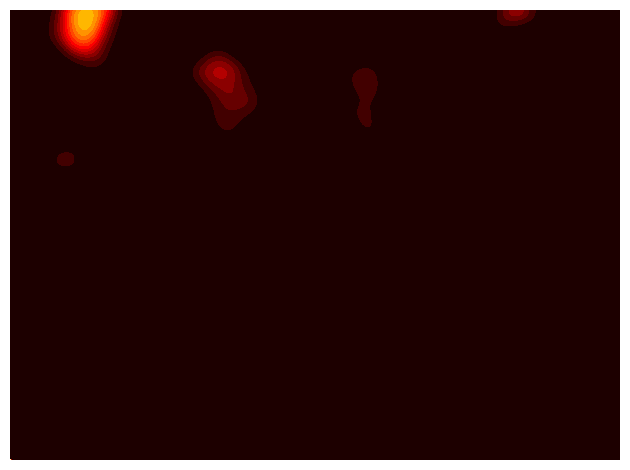

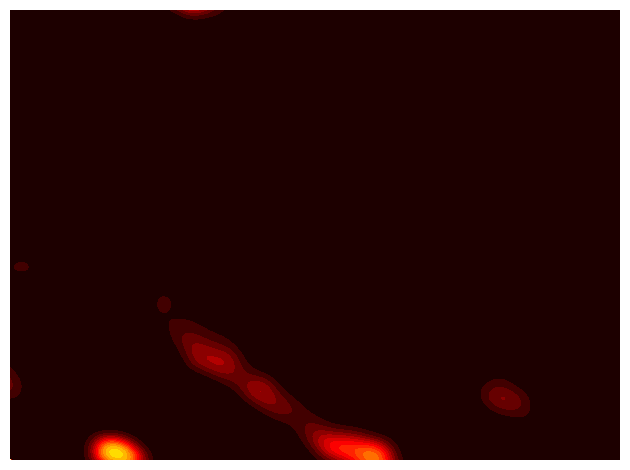

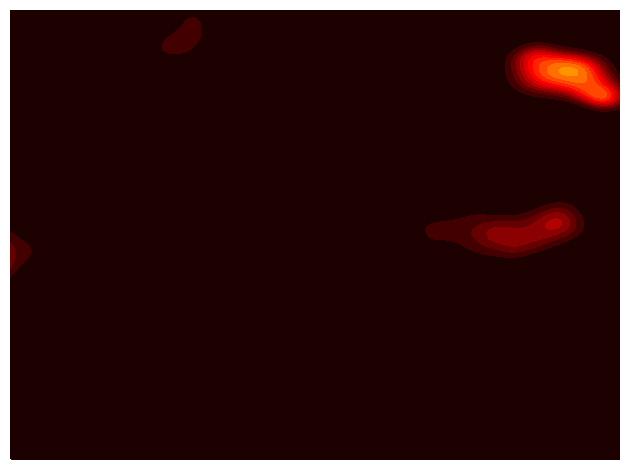

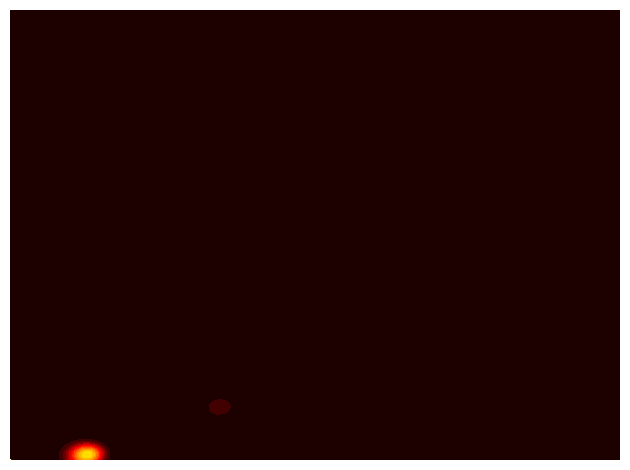

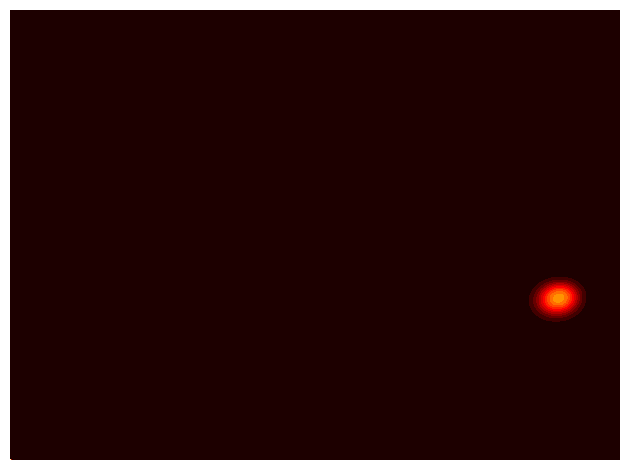

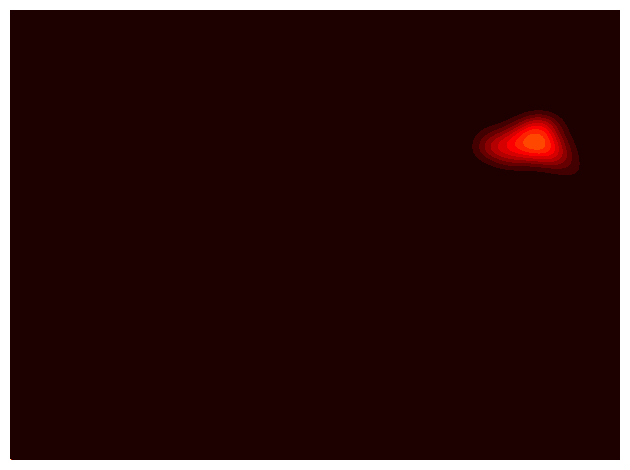

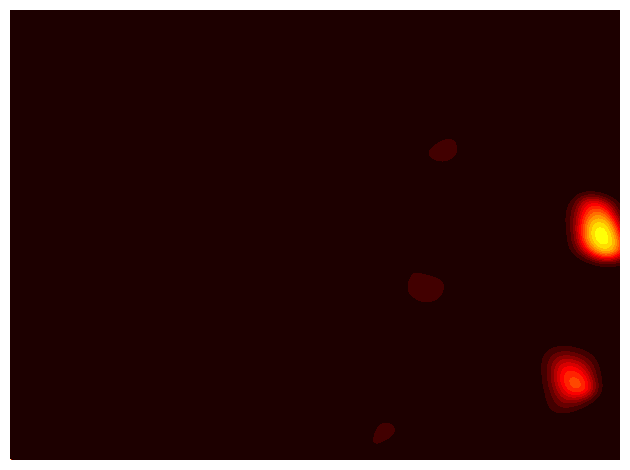

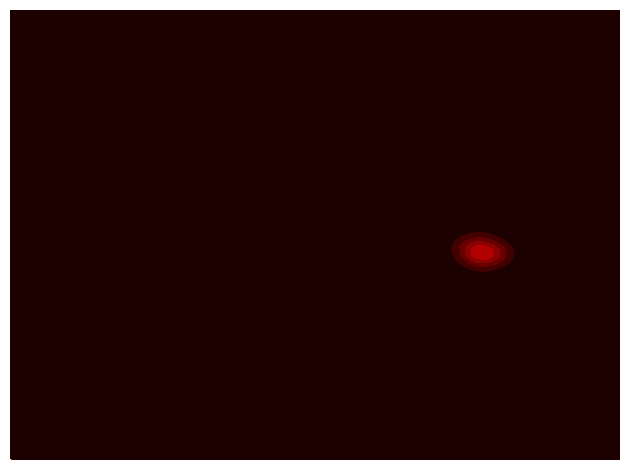

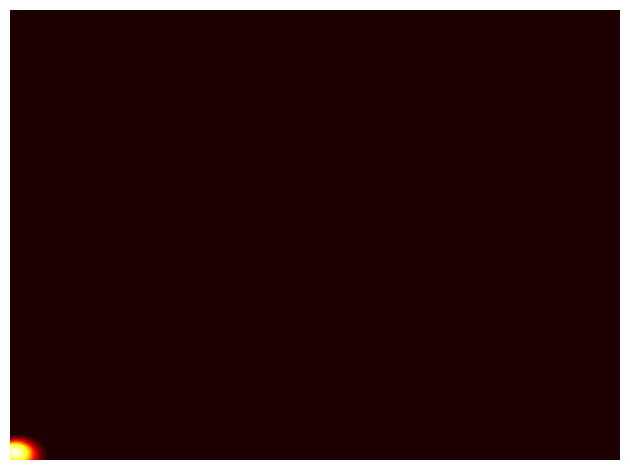

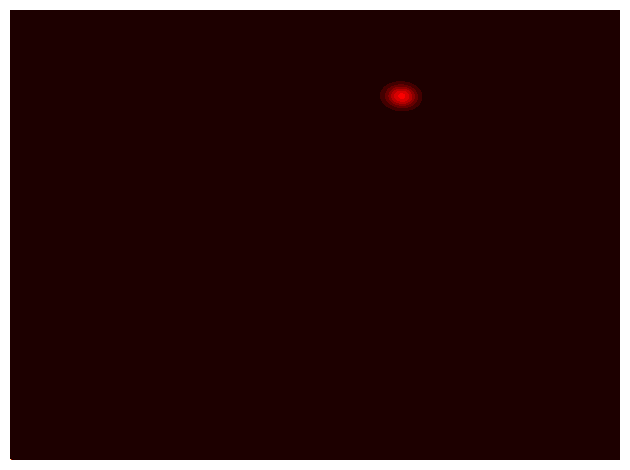

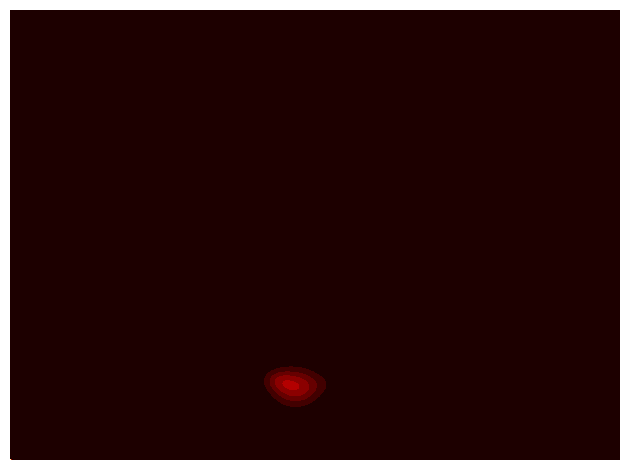

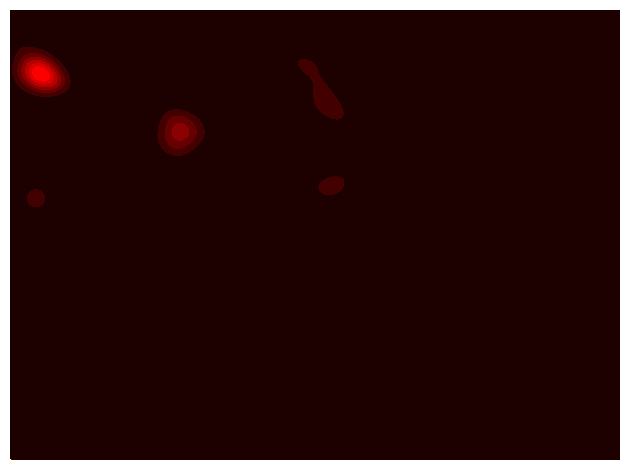

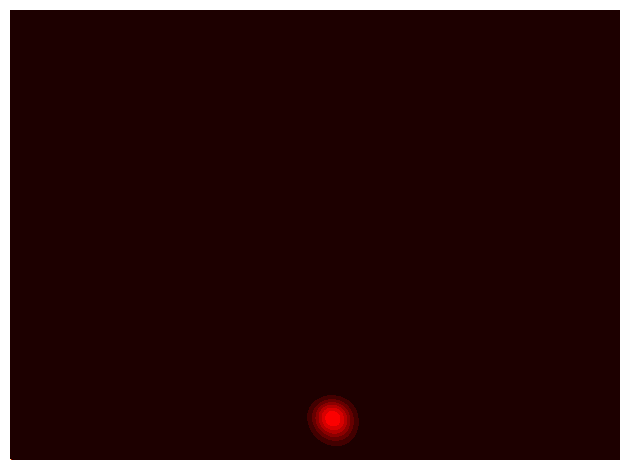

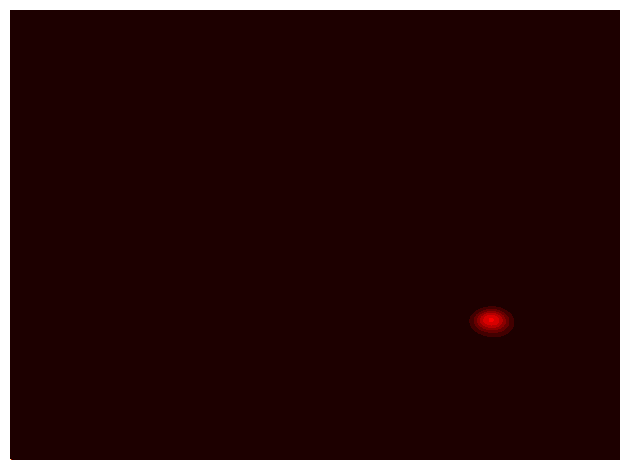

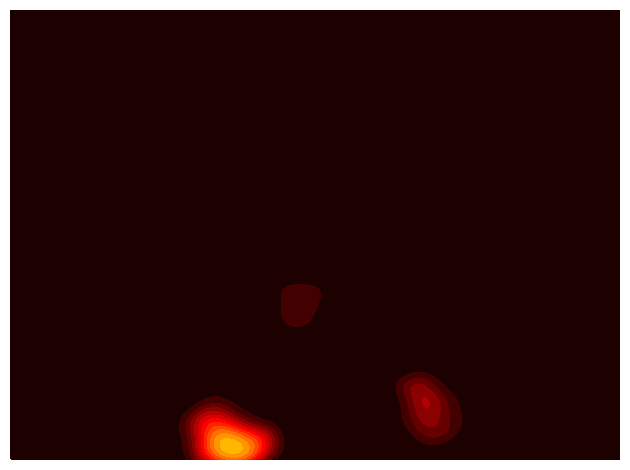

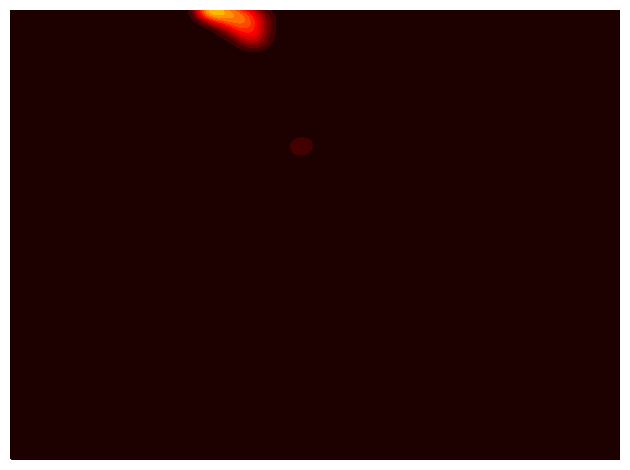

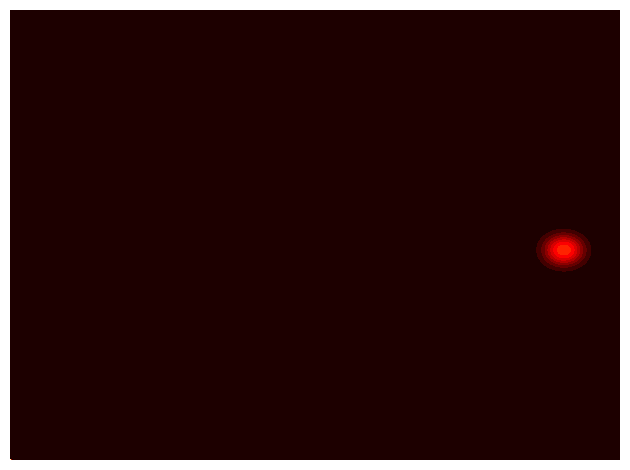

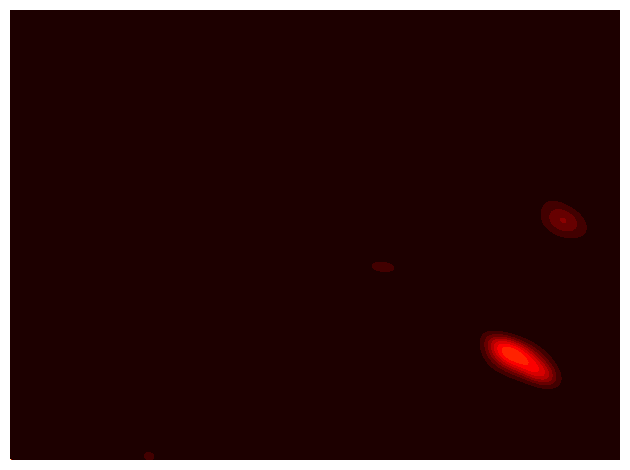

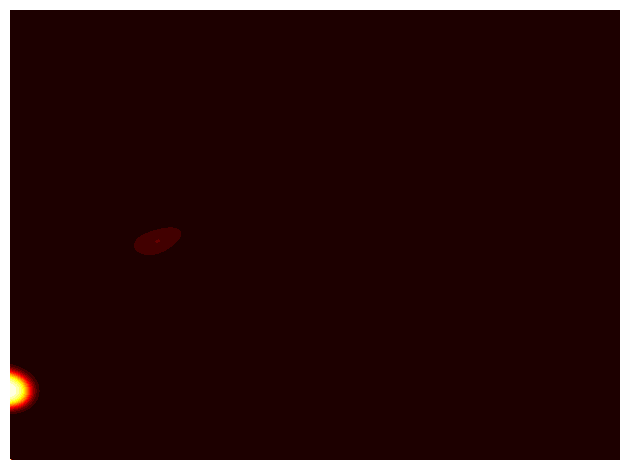

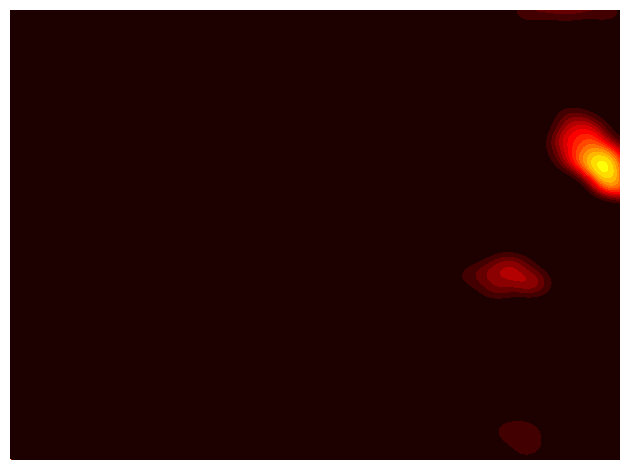

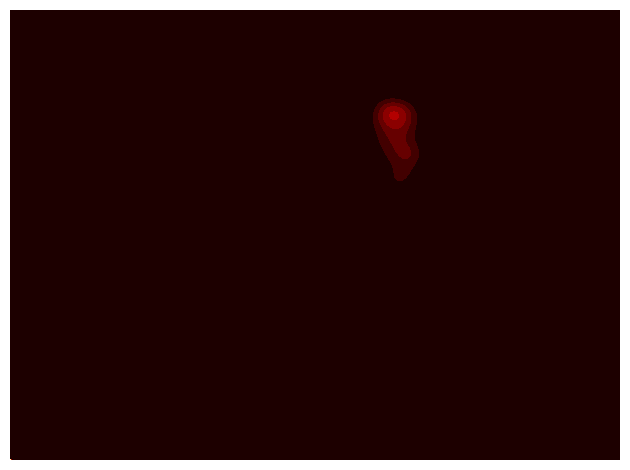

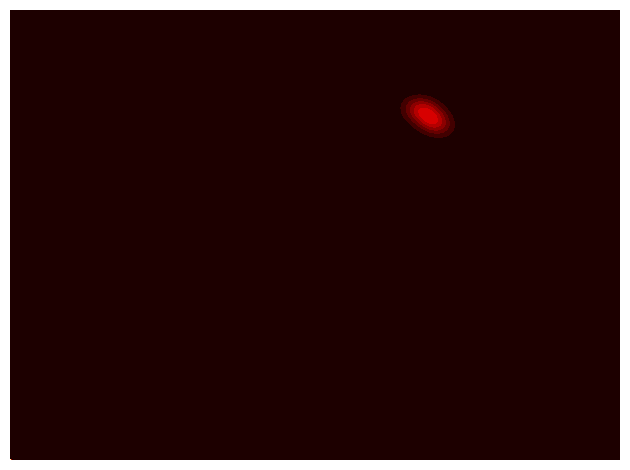

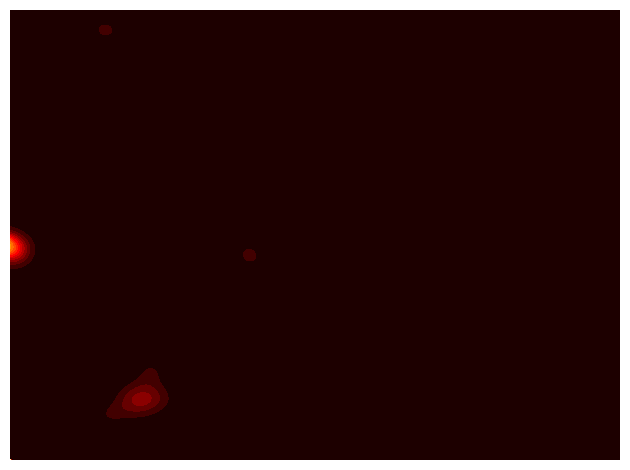

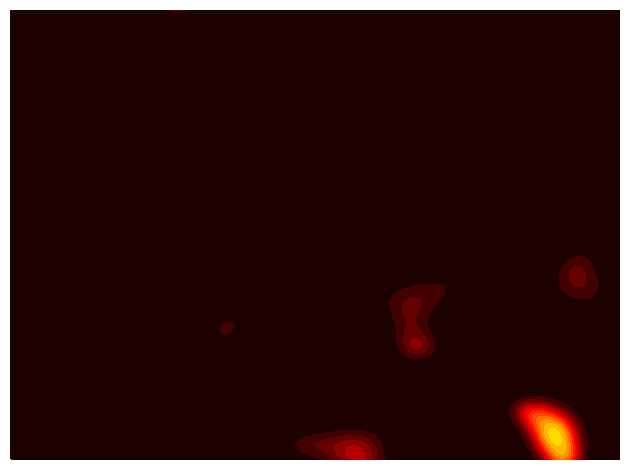

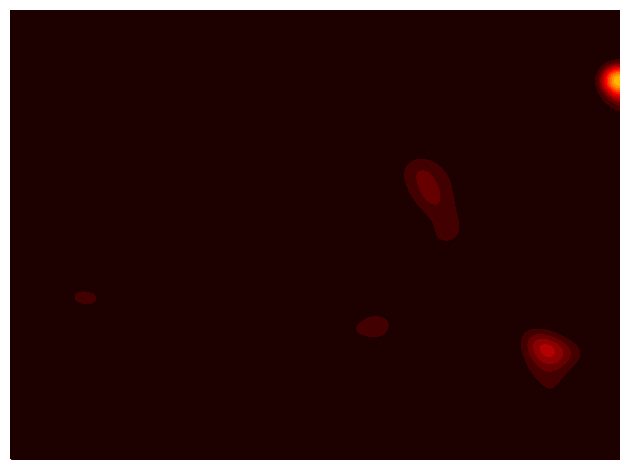

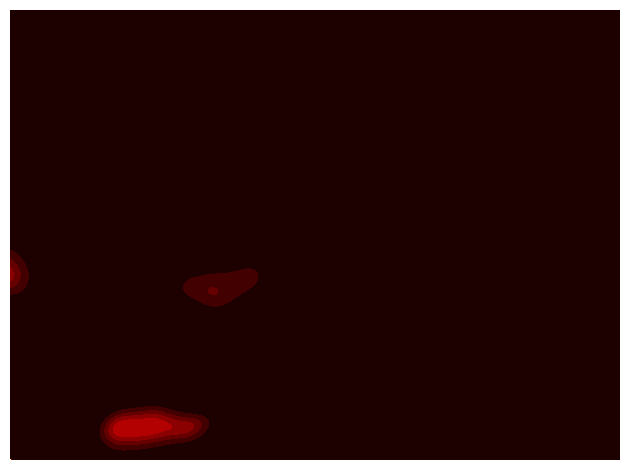

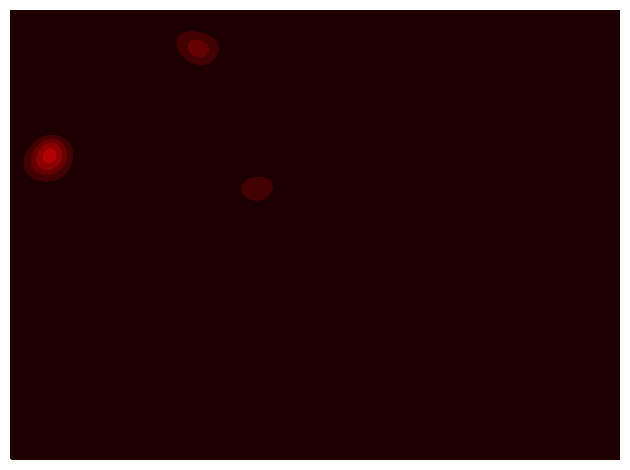

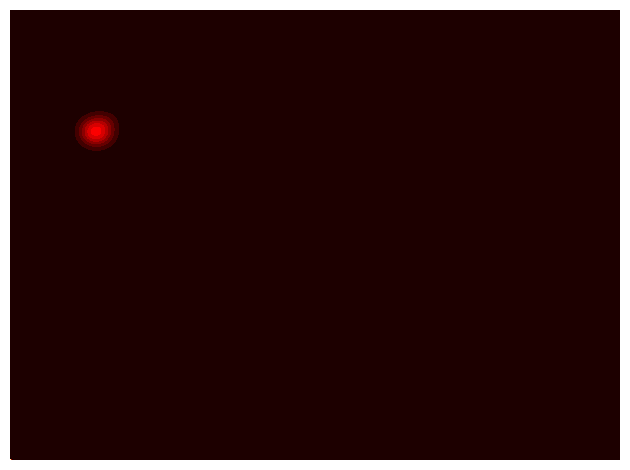

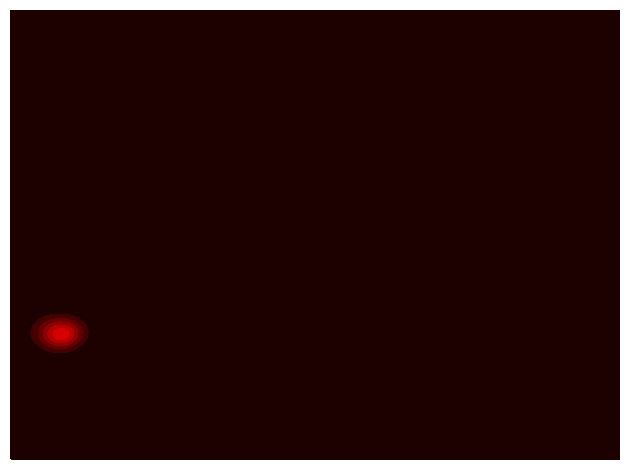

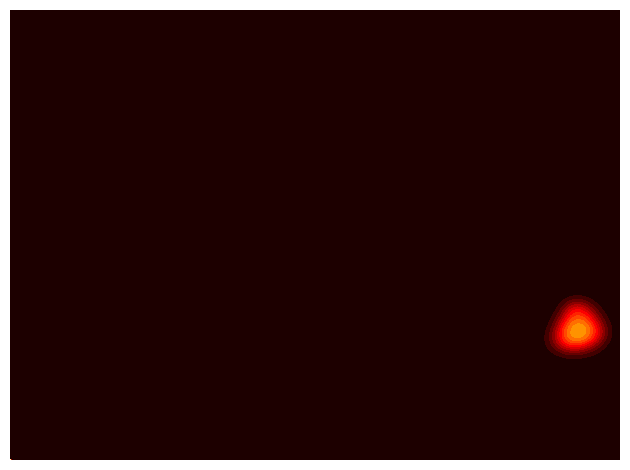

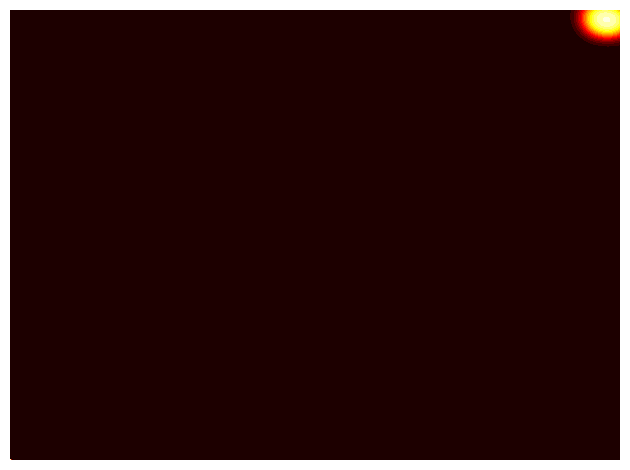

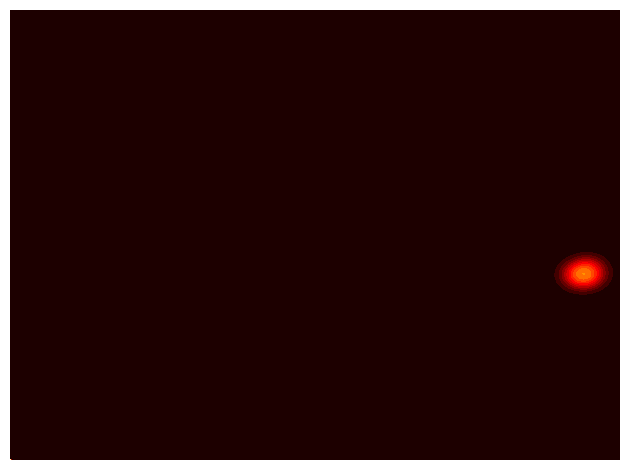

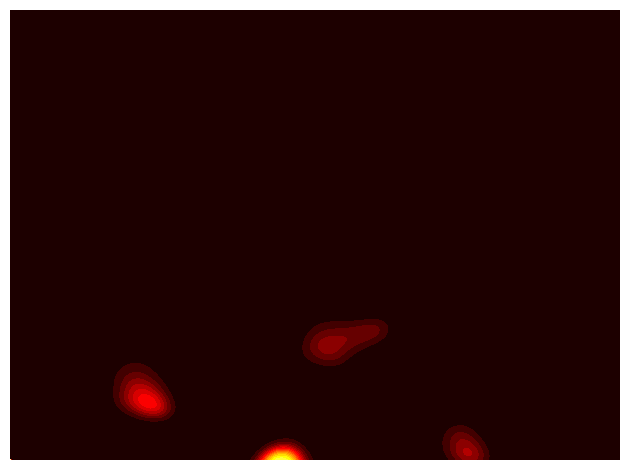

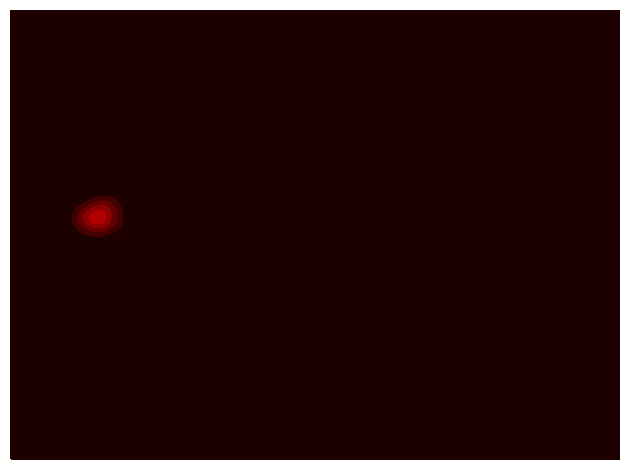

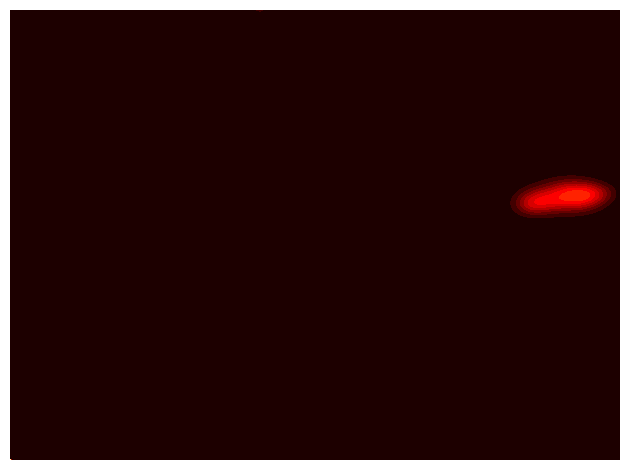

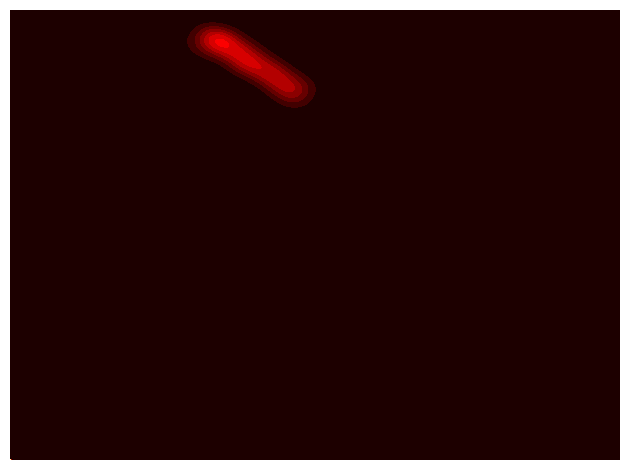

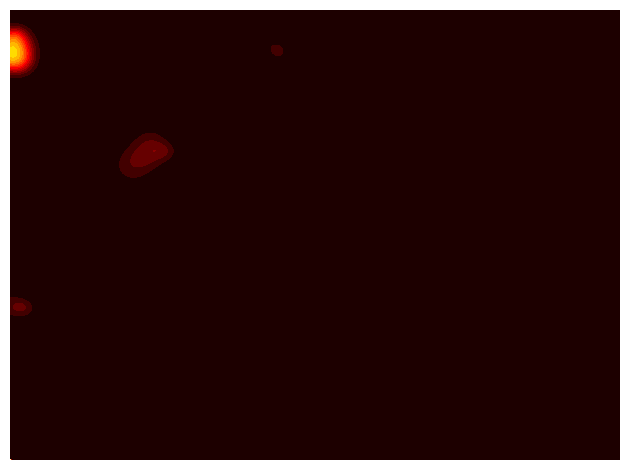

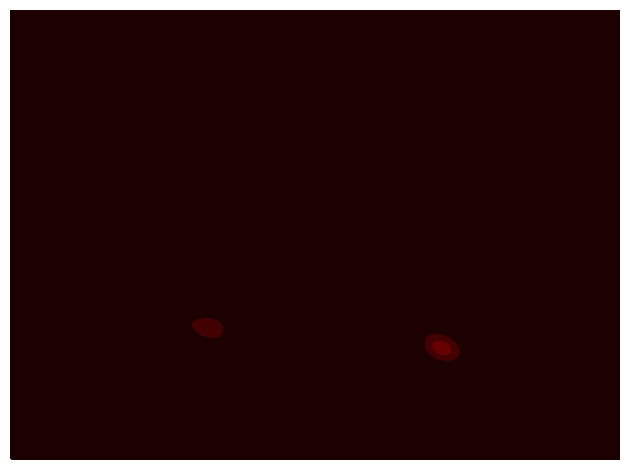

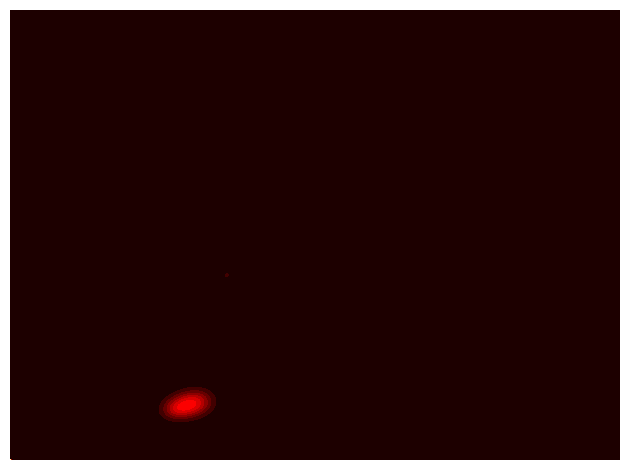

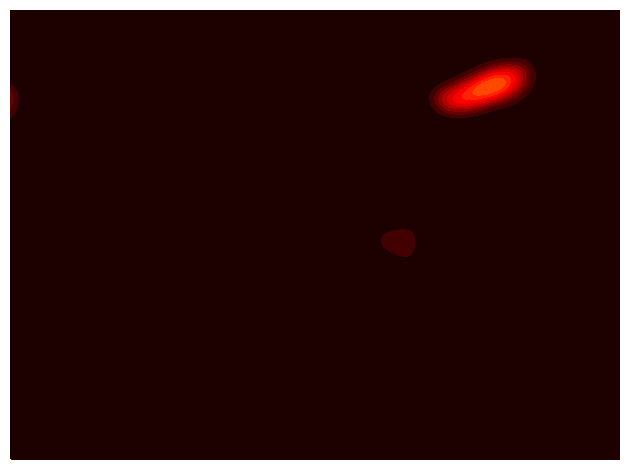

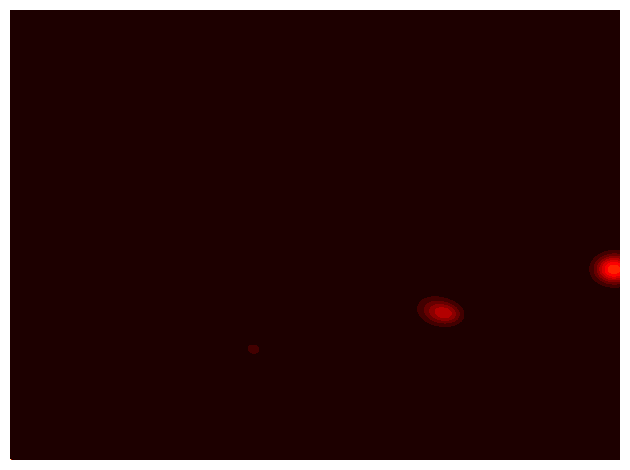

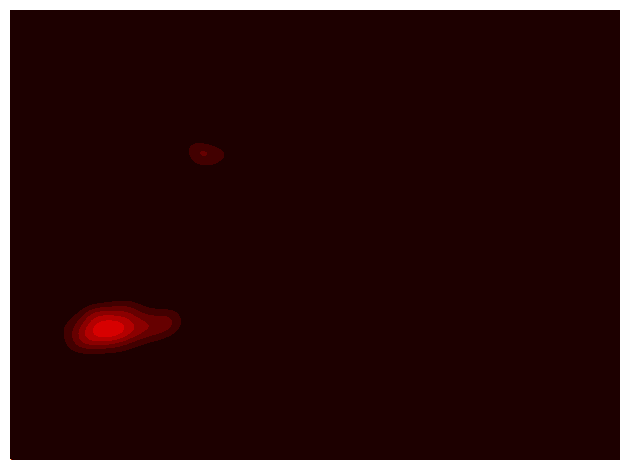

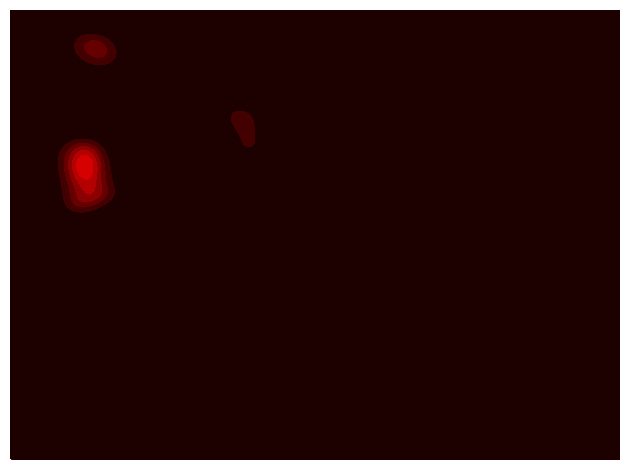

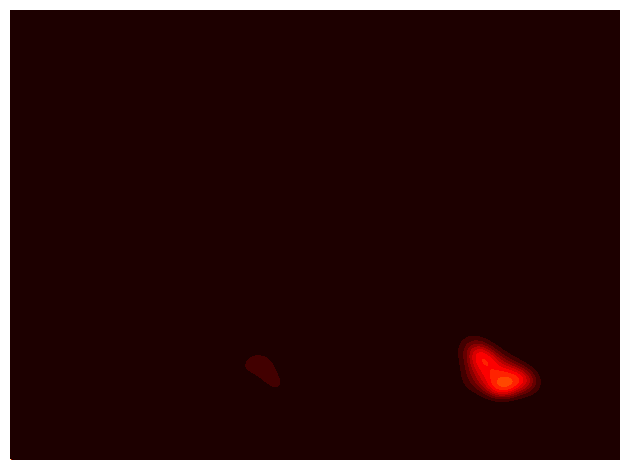

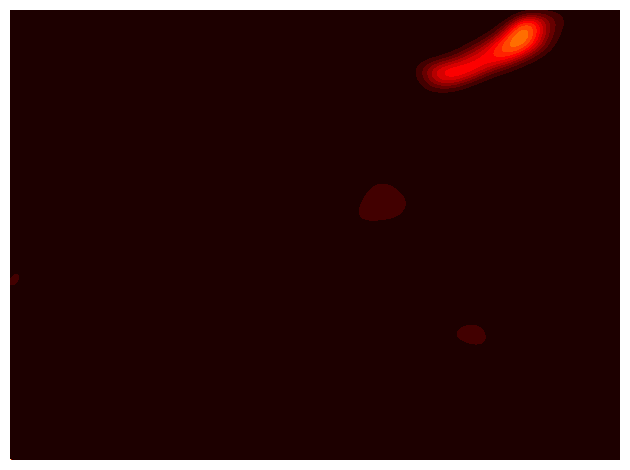

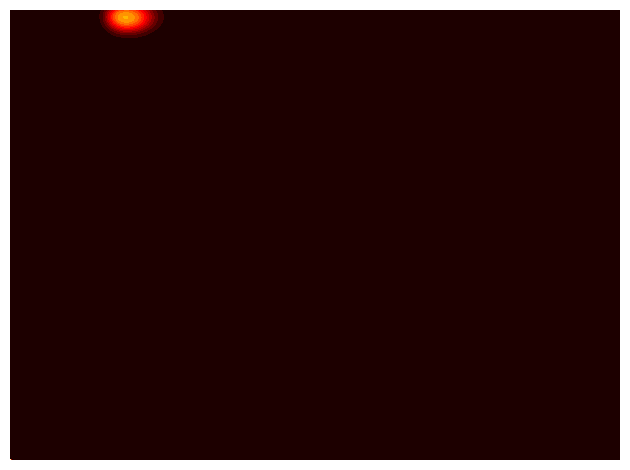

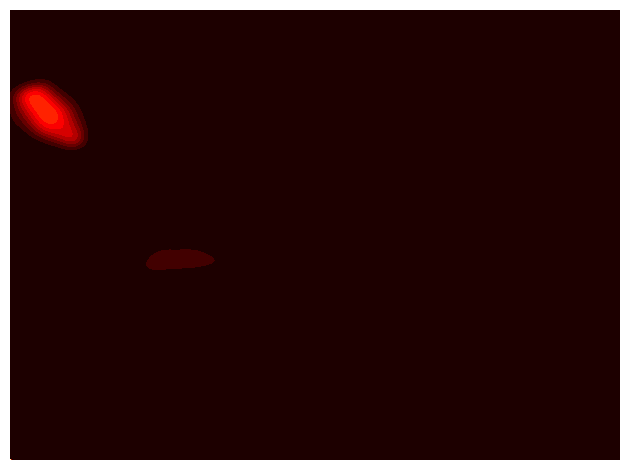

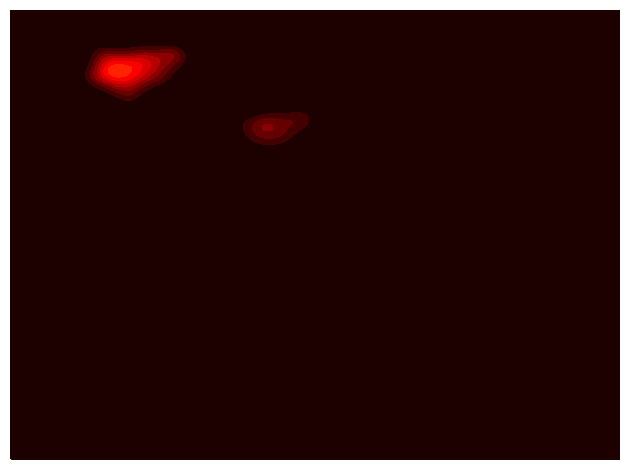

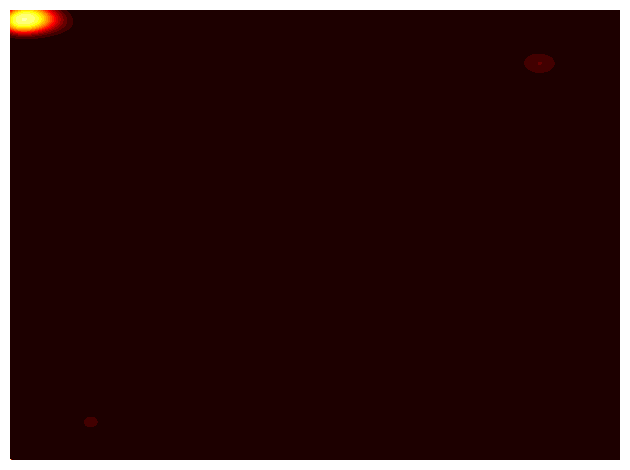

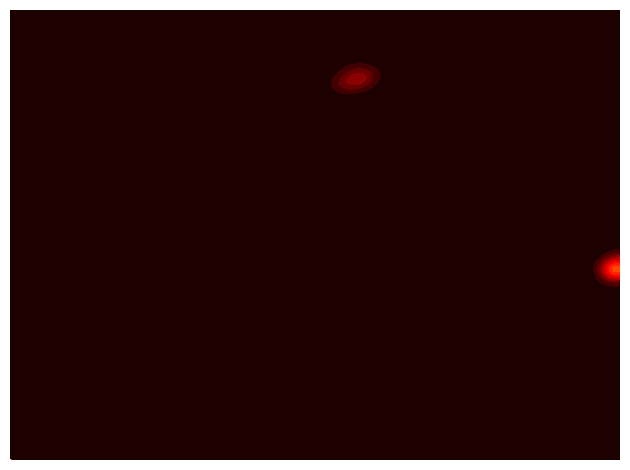

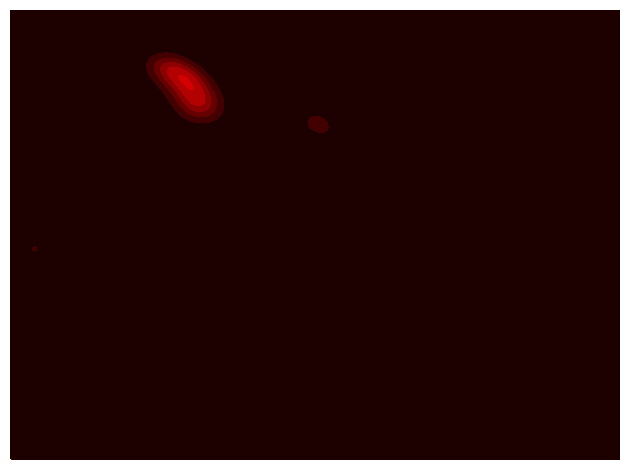

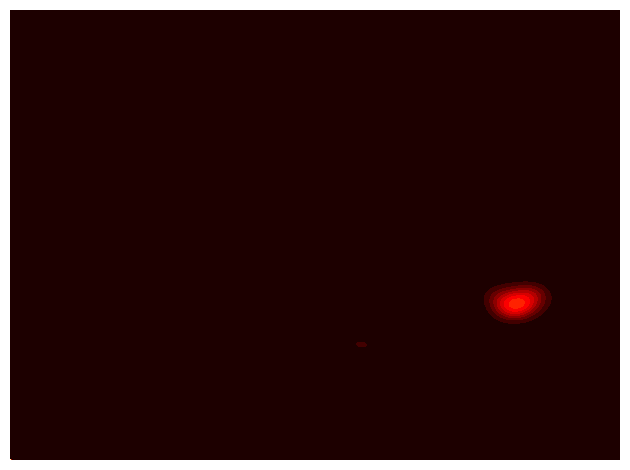

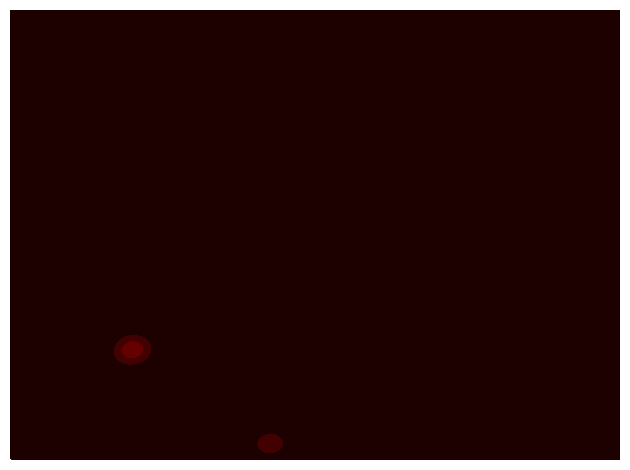

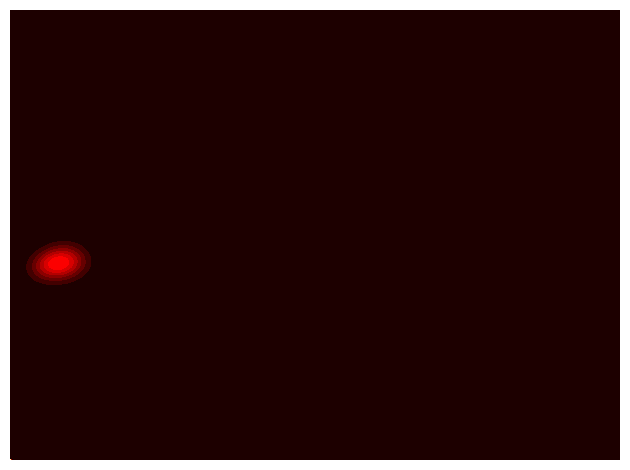

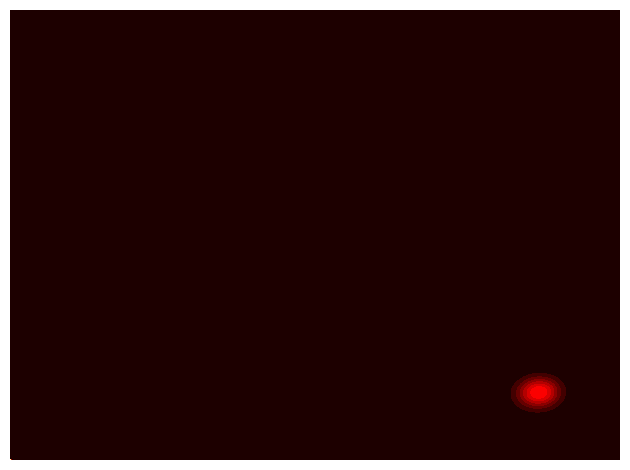

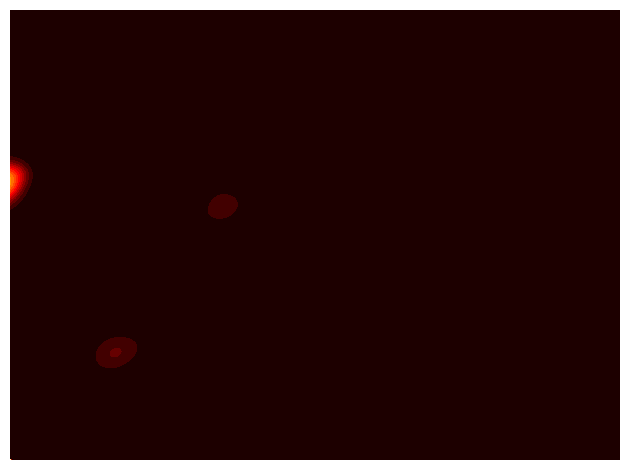

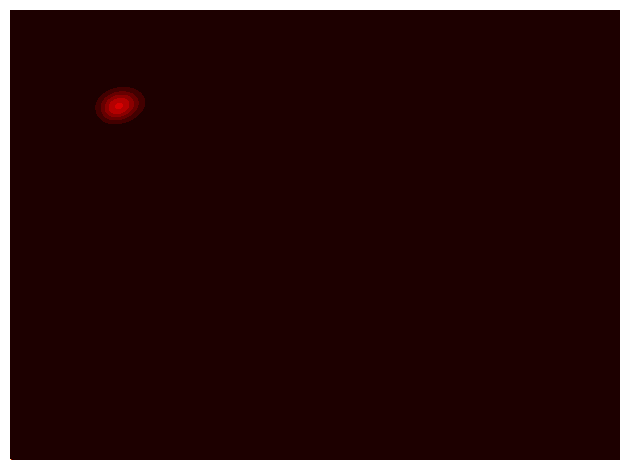

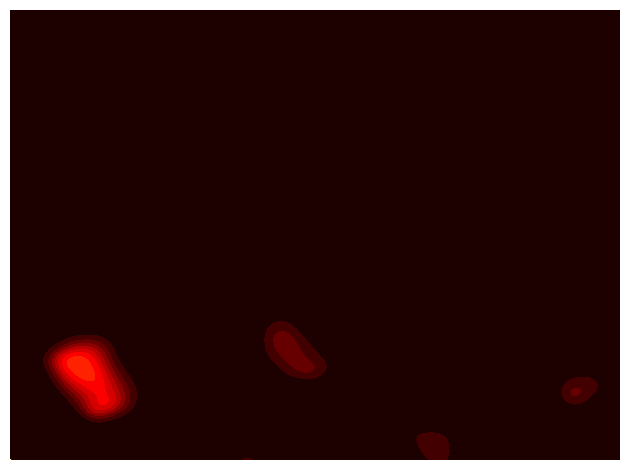

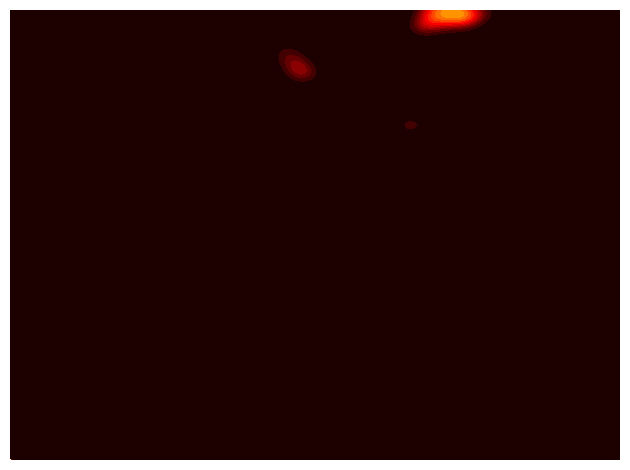

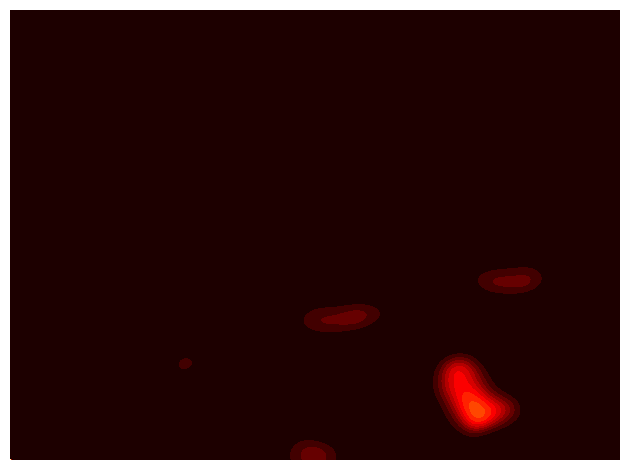

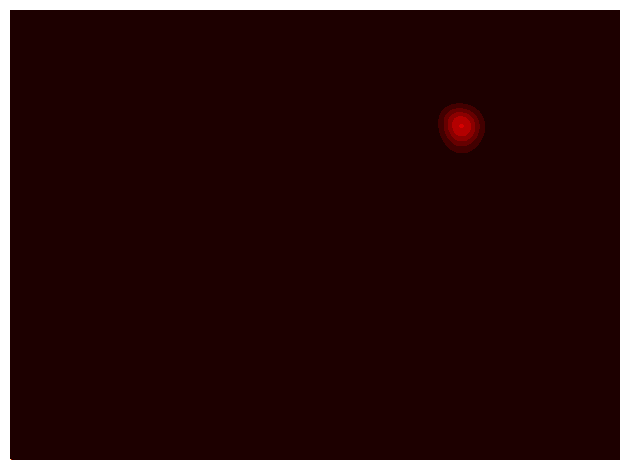

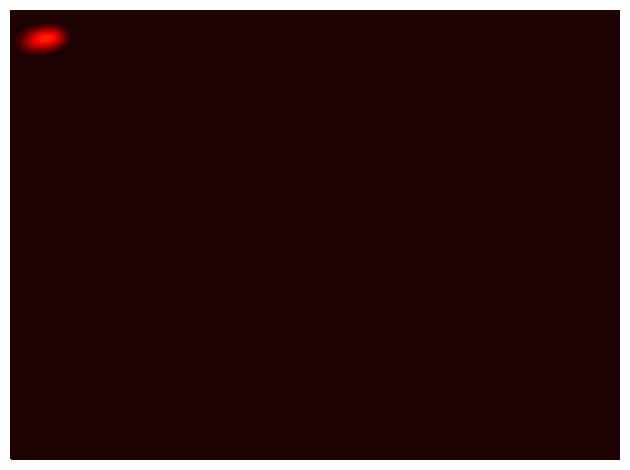

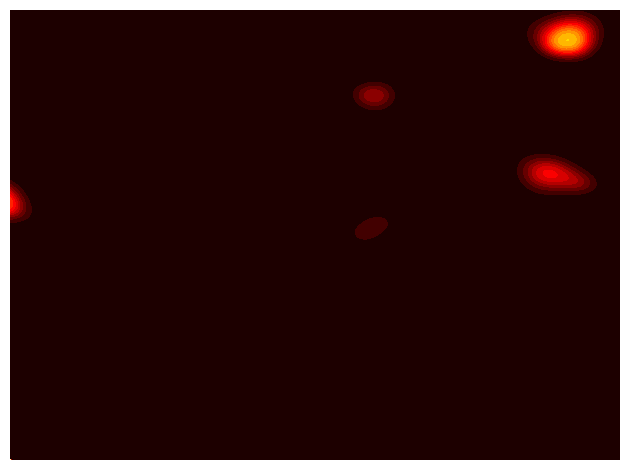

In [17]:
for img in hidden[used]:
    plt.contourf(img, levels=20, cmap='hot')
    plt.axis('off')
    plt.tight_layout()
    plt.show()